In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import matplotlib as mpl

import os
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
# https://www.dukascopy.com/trading-tools/widgets/quotes/historical_data_feed

file = 'INVEB.SESEK_Candlestick_1_M_BID_01.08.2019-12.07.2022.csv'

#file = 'DEU.IDXEUR_Candlestick_1_M_BID_01.08.2019-16.07.2022.csv'
#file = 'HMB.SESEK_Candlestick_1_M_BID_01.08.2019-13.07.2022.csv'

#file = 'XAUUSD_Candlestick_1_M_BID_01.08.2019-09.07.2022.csv'
#file = 'NDA.SESEK_Candlestick_1_M_BID_01.08.2019-16.07.2022.csv'
#file = 'ERICB.SESEK_Candlestick_1_M_BID_01.08.2019-23.07.2022.csv'
#file = 'SEBA.SESEK_Candlestick_1_M_BID_01.08.2019-23.07.2022.csv'
#file = 'TLSN.SESEK_Candlestick_1_M_BID_01.08.2019-23.07.2022.csv'

df = pd.read_csv('data\\' + file)
df = df.rename(columns = {'Local time':'datetime'})
df.columns = df.columns.str.lower()
df['datetime'] = pd.to_datetime(df['datetime'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', utc = True).dt.tz_convert(tz='Europe/Stockholm')

#FIX SPLIT
if file[:5] == 'INVEB':
    df.loc[df['datetime'] < '2021-05-19', ['open','high','low','close']] = df.loc[df['datetime'] < '2021-05-19', ['open','high','low','close']]/4

df = df.sort_values(by='datetime')

# STRIP
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time
df['price'] = df[['close', 'open', 'low', 'high']].mean(axis=1)
df = df.drop(columns=['high', 'low', 'open', 'close', 'datetime'])
df.head()

volume        date      time       price
0     91.0000  2019-08-01  09:01:00  114.224500
1  15435.0000  2019-08-01  09:02:00  114.287625
2  22706.0001  2019-08-01  09:03:00  114.374875
3  10161.0003  2019-08-01  09:04:00  114.549375
4  67671.9993  2019-08-01  09:05:00  114.638813

In [4]:
df_price = df.set_index(['date','time'])[['price']].unstack().ffill(axis=1).bfill(axis=1).stack().reset_index()
df_vol = df.set_index(['date','time'])[['volume']].unstack().ffill(axis=1).bfill(axis=1).stack().reset_index()
df = df_price.merge(df_vol , how='right', on=['date', 'time'])

df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

df['datetime_diff'] = df['datetime'].diff()
df['hour_gap'] = df['datetime_diff'] / np.timedelta64(1, 'h')
df['new_day'] = 0
df.loc[df['hour_gap'] > 10,'new_day'] = 1
df['return'] = df['price'].pct_change()
df['return'] = df['return'].add(1)
df.head()

date      time       price      volume            datetime  year  \
0 2019-08-01  09:00:00  114.224500     91.0000 2019-08-01 09:00:00  2019   
1 2019-08-01  09:01:00  114.224500     91.0000 2019-08-01 09:01:00  2019   
2 2019-08-01  09:02:00  114.287625  15435.0000 2019-08-01 09:02:00  2019   
3 2019-08-01  09:03:00  114.374875  22706.0001 2019-08-01 09:03:00  2019   
4 2019-08-01  09:04:00  114.549375  10161.0003 2019-08-01 09:04:00  2019   

   month  day  hour   datetime_diff  hour_gap  new_day    return  
0      8    1     9             NaT       NaN        0       NaN  
1      8    1     9 0 days 00:01:00  0.016667        0  1.000000  
2      8    1     9 0 days 00:01:00  0.016667        0  1.000553  
3      8    1     9 0 days 00:01:00  0.016667        0  1.000763  
4      8    1     9 0 days 00:01:00  0.016667        0  1.001526

<AxesSubplot:xlabel='datetime'>

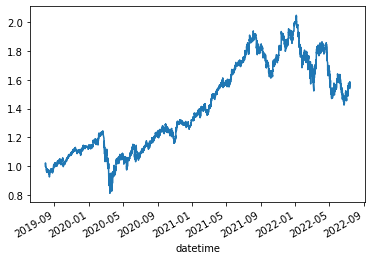

In [5]:
df.set_index(['datetime'])['return'].cumprod().plot()

In [6]:
df.head()

date      time       price      volume            datetime  year  \
0 2019-08-01  09:00:00  114.224500     91.0000 2019-08-01 09:00:00  2019   
1 2019-08-01  09:01:00  114.224500     91.0000 2019-08-01 09:01:00  2019   
2 2019-08-01  09:02:00  114.287625  15435.0000 2019-08-01 09:02:00  2019   
3 2019-08-01  09:03:00  114.374875  22706.0001 2019-08-01 09:03:00  2019   
4 2019-08-01  09:04:00  114.549375  10161.0003 2019-08-01 09:04:00  2019   

   month  day  hour   datetime_diff  hour_gap  new_day    return  
0      8    1     9             NaT       NaN        0       NaN  
1      8    1     9 0 days 00:01:00  0.016667        0  1.000000  
2      8    1     9 0 days 00:01:00  0.016667        0  1.000553  
3      8    1     9 0 days 00:01:00  0.016667        0  1.000763  
4      8    1     9 0 days 00:01:00  0.016667        0  1.001526

In [23]:
#df = df.set_index(['date','time'])
#df['return_cumday'] = df['price'].unstack().pct_change(axis = 1).add(1).cumprod(axis=1).stack()
#df['price_max_day'] = df['price'].unstack().cummax(axis = 1).stack()
    

for minutes in [20, 60, 120, 240, 480]:
    #df['return_'+str(minutes)+'min'] = df['price'].pct_change(minutes).add(1)
    #df['return_'+str(minutes)+'min_shifted'] = df['return_'+str(minutes)+'min']
    
    #df['return_'+str(minutes)+'min_avg'] = df['return'].rolling(minutes).mean()
    #df['return_'+str(minutes)+'min_median'] = df['return'].rolling(minutes).median()
    #df['feat_return_'+str(minutes)+'min_std'] = df['return'].rolling(minutes).std()
    
    
    #df['feat_price_'+str(minutes)+'min'] = df['price'].rolling(minutes).mean()
    df['feat_price_'+str(minutes)+'min_max'] = df['price'].rolling(minutes).max()
    df['feat_price_'+str(minutes)+'min_max_shifted'] = df['feat_price_'+str(minutes)+'min_max'].shift(minutes)
    df['feat_price_'+str(minutes)+'min_min'] = df['price'].rolling(minutes).min()
    df['feat_price_'+str(minutes)+'min_min_shifted'] = df['feat_price_'+str(minutes)+'min_min'].shift(minutes)
    
#df = df.reset_index()

features = [column for column in df.columns if 'feat_' in column]
df[features] = df[features].div(df['price'], axis=0)

df.tail(5)

date      time      price       volume            datetime  year  \
374200 2022-07-12  17:20:00  180.55425  546559.9895 2022-07-12 17:20:00  2022   
374201 2022-07-12  17:21:00  180.53350  325580.0009 2022-07-12 17:21:00  2022   
374202 2022-07-12  17:22:00  180.57875  275660.0082 2022-07-12 17:22:00  2022   
374203 2022-07-12  17:23:00  180.67200  233640.0002 2022-07-12 17:23:00  2022   
374204 2022-07-12  17:24:00  180.79125  293660.0149 2022-07-12 17:24:00  2022   

        month  day  hour   datetime_diff  ...  price_pct_up  price_pct_down  \
374200      7   12    17 0 days 00:01:00  ...             0               0   
374201      7   12    17 0 days 00:01:00  ...             0               0   
374202      7   12    17 0 days 00:01:00  ...             0               0   
374203      7   12    17 0 days 00:01:00  ...             0               0   
374204      7   12    17 0 days 00:01:00  ...             0               0   

        pred_price_pct_up  pred_price_pct_down  action  price_buy  \
374200           0.236954             0.218198     NaN        NaN   
374201           0.236954             0.218198     NaN        NaN   
374202           0.236954             0.223152     NaN        NaN   
374203           0.236954             0.223152     NaN        NaN   
374204           0.306349             0.223152     NaN        NaN   

        feat_price_480min_max  feat_price_480min_max_shifted  \
374200               1.000197                       0.990524   
374201               1.000312                       0.990637   
374202               1.000061                       0.990389   
374203               1.000000                       0.989878   
374204               1.000000                       0.989225   

        feat_price_480min_min  feat_price_480min_min_shifted  
374200               0.973407                       0.976090  
374201               0.973519                       0.975690  
374202               0.973275                       0.974875  
374203               0.972772                       0.973221  
374204               0.972131                       0.972579  

[5 rows x 40 columns]

In [8]:
#df.loc[df['new_day']==1, 'feat_return_new_day'] = df['return']
#df['feat_return_new_day'] = df['feat_return_new_day'].ffill()
#features = [column for column in df.columns if 'feat_' in column]
#df.tail()

## DO ML

In [9]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics 
from sklearn import tree

In [49]:
hold_time_h = 1
pct_change = 0.005

df['price_pct'] = df['price'].shift(-hold_time_h*60).rolling(hold_time_h*60).max().div(df['price'])
df['price_pct_up'] = 0
df.loc[df['price_pct']>1 + pct_change, 'price_pct_up'] = 1

df['price_pct'] = df['price'].shift(-hold_time_h*60).rolling(hold_time_h*60).min().div(df['price'])
df['price_pct_down'] = 0
df.loc[df['price_pct']<1 - pct_change, 'price_pct_down'] = 1

print(df['price_pct_up'].mean())
print(df['price_pct_down'].mean())

0.1616680696409722
0.15562592696516614


In [58]:
from datetime import time

corona_low = '2020-03-01'
corona_high = '2020-05-01'
from_date = '2018-01-01'
to_date = '2022-01-01'
df_train = df[((df['date']<corona_low) | (df['date']>corona_high))  & 
              ((df['date']>from_date) & (df['date']<to_date))
            & ((df['time']>time(8, 0)) & (df['time']<time(16, 30)))
             ].copy()
df_test = df[((df['date']>=to_date))].copy()

In [59]:
#MODEL
X = df_train.loc[:, features]
Y = df_train.loc[:, 'price_pct_up']

scale_pos_weight = Y[Y == 0].count()/Y[Y==1].count()
print('scale pos: ',scale_pos_weight)

model = XGBClassifier(#scale_pos_weight = scale_pos_weight, 
                      max_depth = 3, eval_metric="error",
                      n_jobs = 8, use_label_encoder=False)

model.fit(X, Y, eval_metric="error",
          #eval_set=eval_set,
          verbose=False)

scale pos:  10.427549514910359


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [60]:
X = df.loc[:, features]
Y = df.loc[:, 'price_pct_up']

y_pred = model.predict_proba(X)
#accuracy = accuracy_score(Y, y_pred)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

df['pred_price_pct_up'] = y_pred[:,1]
print(df['pred_price_pct_up'].mean())

0.12145938724279404


### SELL

In [61]:
X = df_train.loc[:, features]
Y = df_train.loc[:, 'price_pct_down']

model = XGBClassifier(#scale_pos_weight = scale_pos_weight, 
                      max_depth = 3, eval_metric="error",
                      n_jobs = 8, use_label_encoder=False)

model.fit(X, Y, eval_metric="error",
          #eval_set=eval_set,
          verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [62]:
X = df.loc[:, features]
Y = df.loc[:, 'price_pct_down']

y_pred = model.predict_proba(X)
#accuracy = accuracy_score(Y, y_pred)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

df['pred_price_pct_down'] = y_pred[:,1]
print(df['pred_price_pct_down'].mean())

0.1169874370098114


# MAKE MODELS

In [55]:
df['action'] = np.nan
df['price_buy'] = np.nan

buy_strategy = 'ml'
sell_strategy = 'ml'

signal = 'avg'

# BUY
if buy_strategy == 'ml':
    #df['action'] = df['pred_price_pct_up'] - df['pred_price_pct_down']
    df.loc[df['pred_price_pct_up']>0.5, 'action'] = 1

if sell_strategy == 'ml':
    #df['action'] = df['pred_price_pct_up'] - df['pred_price_pct_down']
    df.loc[df['pred_price_pct_down']>0.5, 'action'] = -1
    
#df['action'] = df.groupby('date')['action'].ffill()
    
if buy_strategy == 'blank':
    pass
    
    
# Momentum
if buy_strategy == 'momentum':
    df.loc[#(df['return_new_day'].sub(1).abs()>=0.005) &# (df['return_new_day']>1) &
           (df['price_30min_min']>df['price_60min_min']) &
           (df[f'return_5min_{signal}']>df[f'return_10min_{signal}'])
           & (df[f'feat_return_30min_std']>df[f'feat_return_60min_std'])
           & (df[f'feat_return_15min_std']>df[f'feat_return_30min_std'])
           & (df[f'return_10min_{signal}']>df[f'return_15min_{signal}'])
           & (df[f'return_15min_{signal}']>df[f'return_30min_{signal}'])
           #& (df['return_20min_avg']>df['return_30min_avg'])
           #& (df['price']==df['price_60min_max'])
           #& (df['return_10min_std']>df['return_20min_std'])
           #& (df['return_cumday_30min_avg']>df['return_cumday_60min_avg'])
           #& (df['price'] >= df['price_max_day']) &
           #& (df['return_30min_median']>1)
           , 'action'] = 1


# Pullback
if buy_strategy == 'pullback':
    df.loc[(df['return_5min']>df['return_10min']) & 
           (df['return_10min']<df['return_15min']) & 
           (df['return_15min']<df['return_20min']) & 
           (df['return_20min']<df['return_30min']), 'action'] = 1
    


df.loc[df['action']==1, 'price_buy'] = df['price']
df['price_buy'] = df.groupby('date')['price_buy'].ffill()
    
    
if sell_strategy == 'time':
    df['action'] = df.groupby('date')['action'].ffill(limit=2*60)
    #df['action'] = df['action'].fillna(-1)
    
if sell_strategy == 'profit':
    df.loc[(df['price'] > df['price_buy']*1.01), 'action'] = -1
    df['action'] = df.groupby('date')['action'].ffill()
    
# SELL
if sell_strategy == 'momentum':
    df.loc[#(df['price']==df['feat_price_60min_min']) &
           (df[f'feat_price_5min']<df[f'feat_price_10min']) &
           (df[f'feat_price_10min']<df[f'feat_price_15min'])
           & (df[f'feat_price_15min']<df[f'feat_price_30min'])
        & (df[f'feat_price_30min']<df[f'feat_price_60min'])
        & (df[f'feat_price_60min']<df[f'feat_price_120min'])
           #& (df[f'return_30min_{signal}']<df[f'return_60min_{signal}'])
           , 'action'] = -1

#df = df.set_index(['date','time'])
#df['price_max'] = df['fika_price'].unstack().cummax(axis=1).stack()
#df = df.reset_index()

#df['fika_sell'] = np.nan
#df.loc[(df['fika_price'] < df['fika_max']*0.995),'fika_sell'] = 1

# HOLD STOCK UNTIL SELL SIGNAL OR DAY END
#if sell_strategy not in ['blank', 'ml']:
#df['action'] = df.groupby('date')['action'].ffill(3*60)
#df['action'] = df.groupby('date')['action'].shift(1)


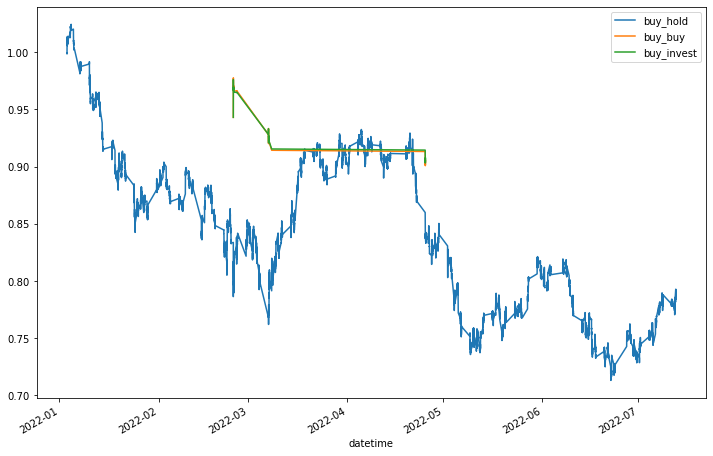

In [35]:
#df['action'] = df['action'].replace(-1,np.nan)
f, ax = plt.subplots(figsize= (12, 8))
df_cell = df[(df['date']>'2022-01-01')]
df_cell.set_index('datetime')['return'].cumprod().plot(ax=ax)
df_cell.loc[df['action']==1].set_index('datetime')['return'].sub(1).cumsum().add(1).plot(ax=ax)
df_cell.loc[df['action']==1].set_index('datetime')['return'].cumprod().plot(ax=ax)
ax.legend(['buy_hold', 'buy_buy', 'buy_invest'])
#df[df['datetime'].isin()]

In [36]:
df['action_number'] = df['action'].replace(-1,0).fillna(0).diff().replace(-1, 0).cumsum()
df_actions = df[(df['action']==1) & (df['year']==2022)].groupby(['action_number'])['return'].agg(('prod', 'count'))
df_actions.sort_values(by='prod')
df_actions['count'].shape[0]/df['date'].nunique()

0.04048582995951417

0.5435909496882108


<AxesSubplot:ylabel='Frequency'>

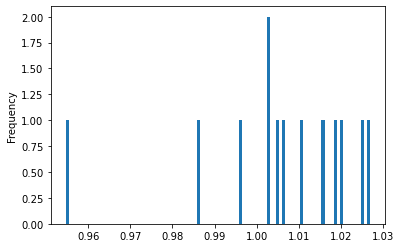

In [48]:
print((df_actions['prod'].mean()-1)*100)
df_actions['prod'].plot(kind='hist', bins=100)

In [209]:
(df_actions['prod'].mean()-1)*100#*100000*10
#df[df['action']==1].groupby('date')['return'].prod().sort_values(ascending=False)

0.0640475244865435

35


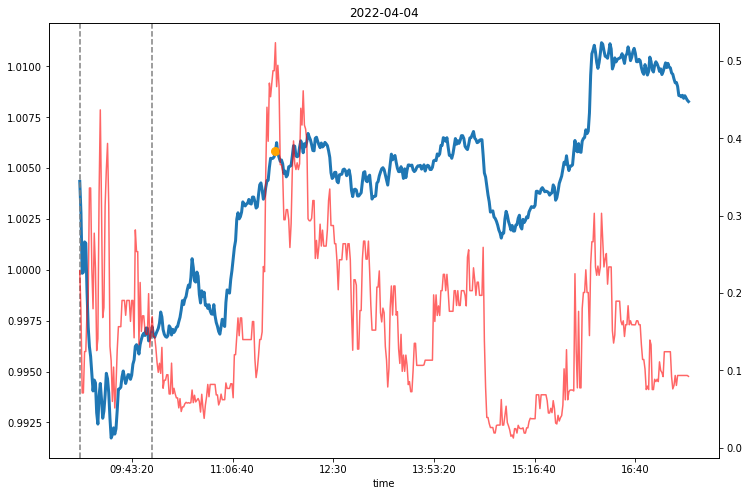

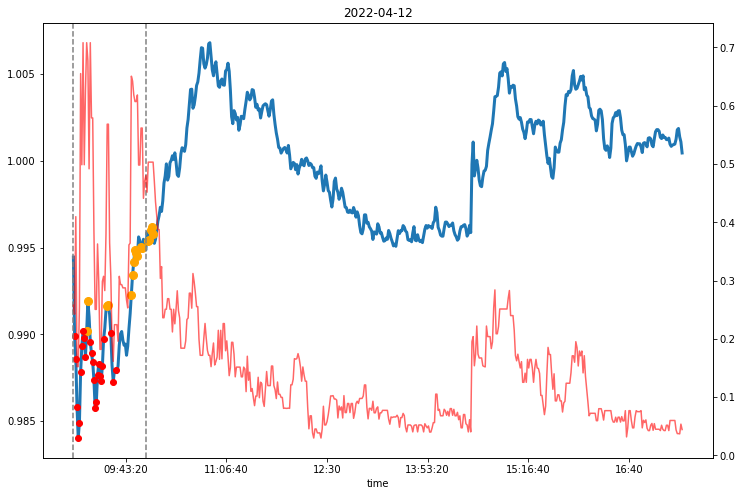

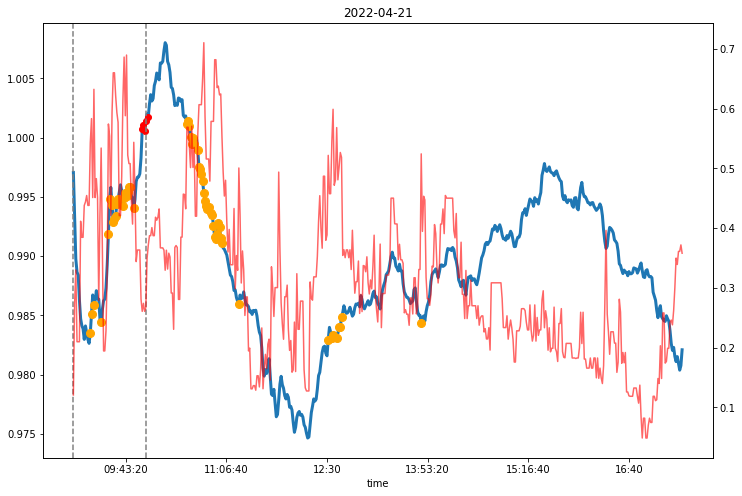

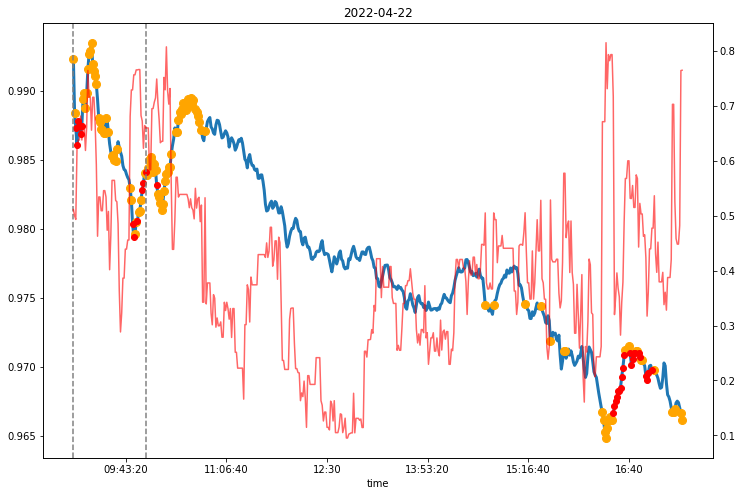

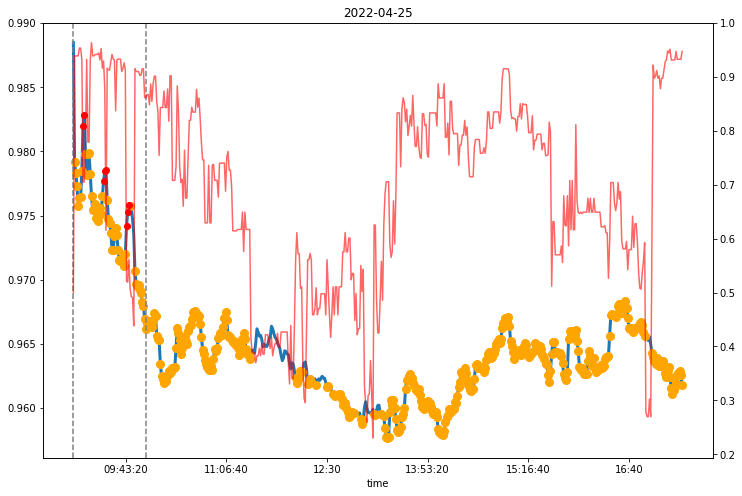

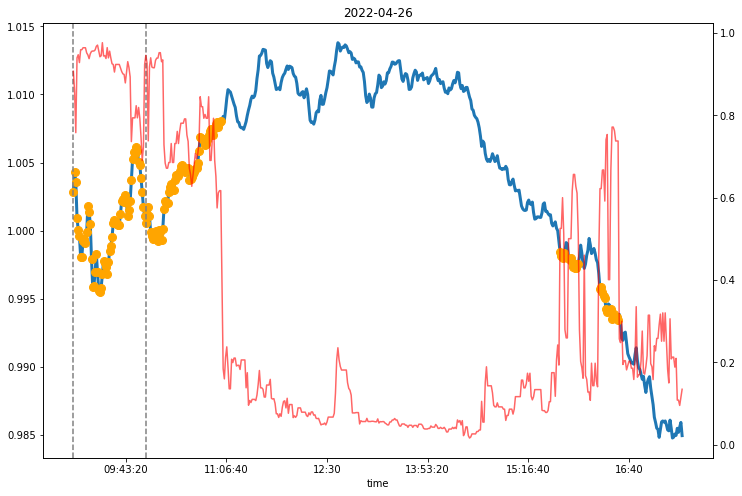

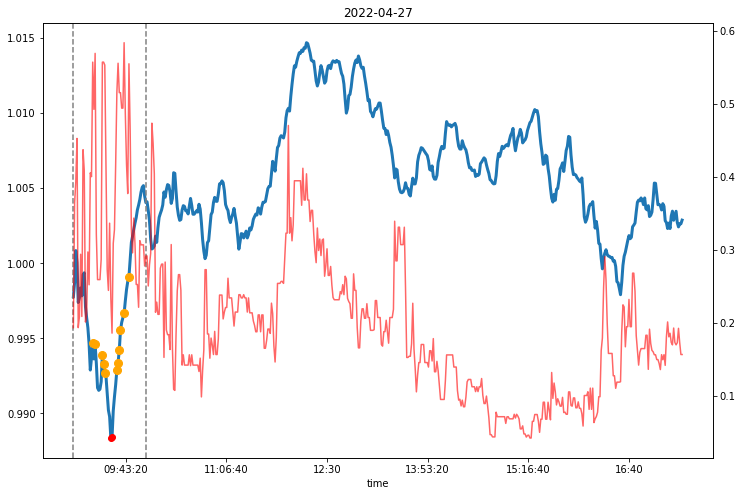

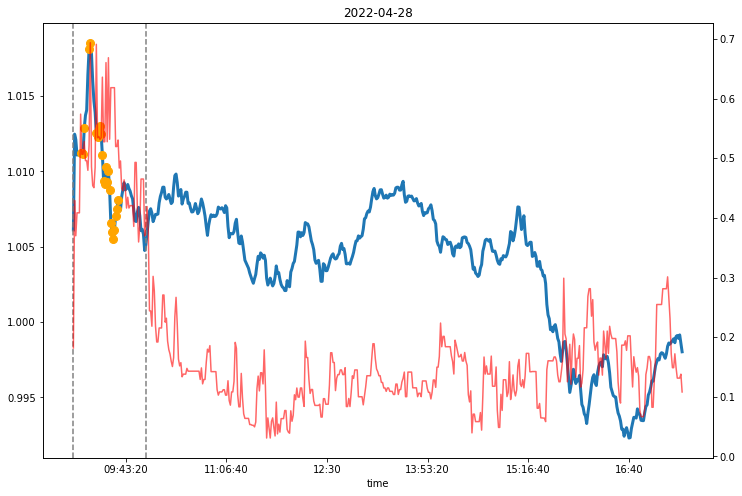

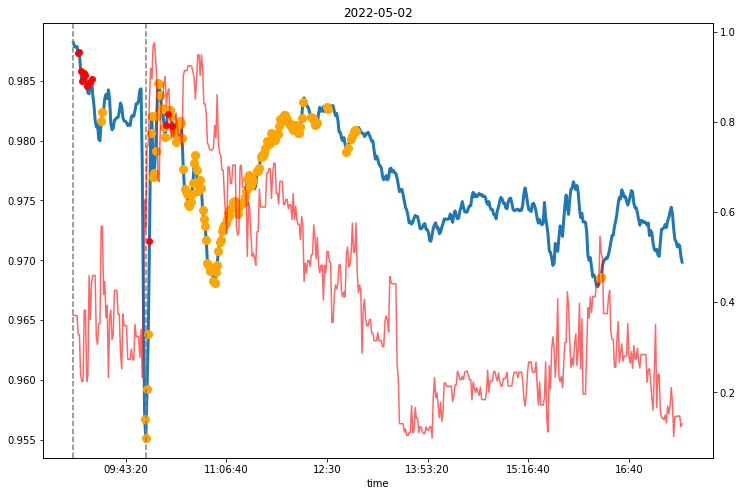

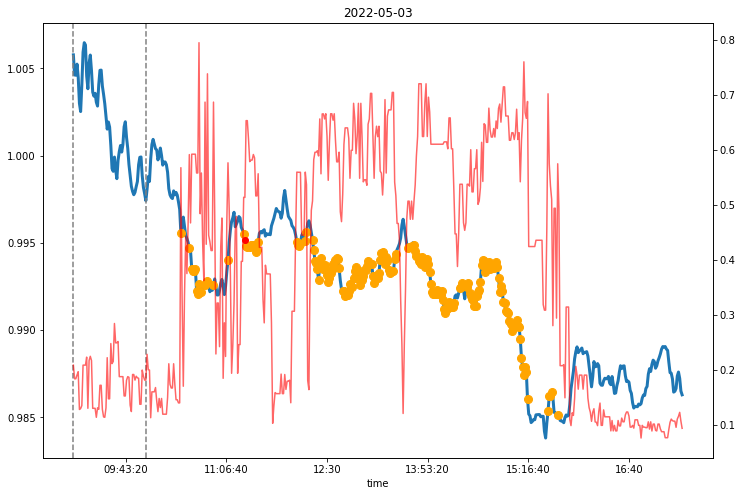

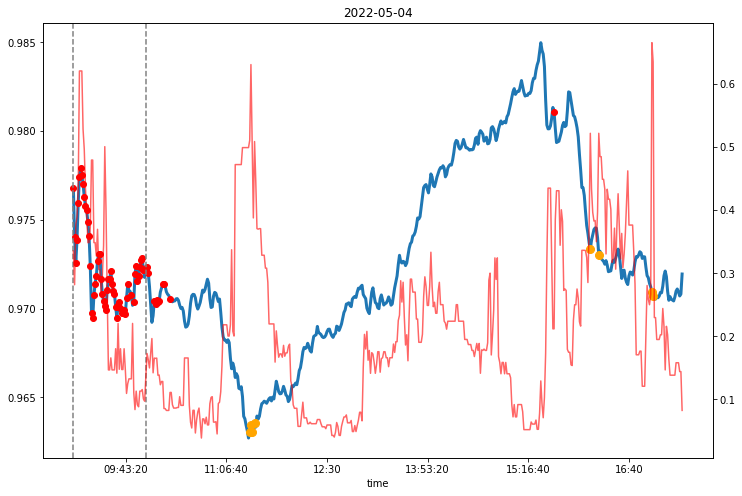

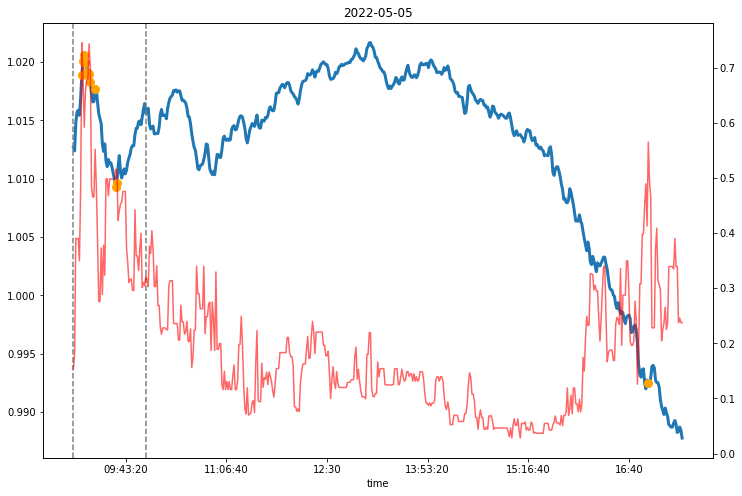

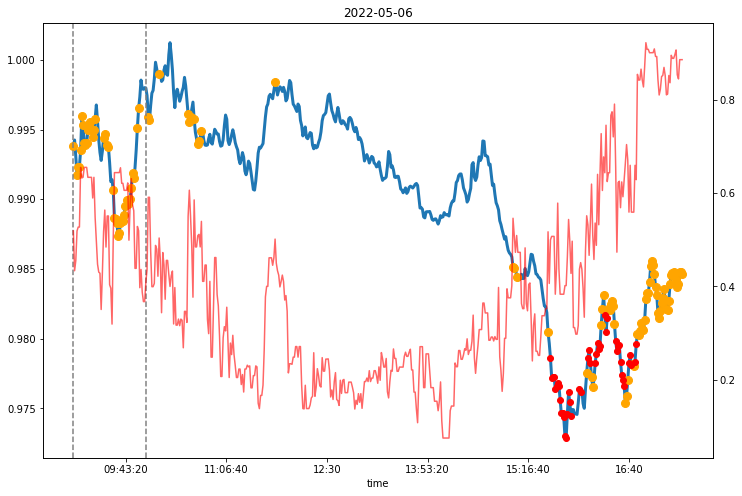

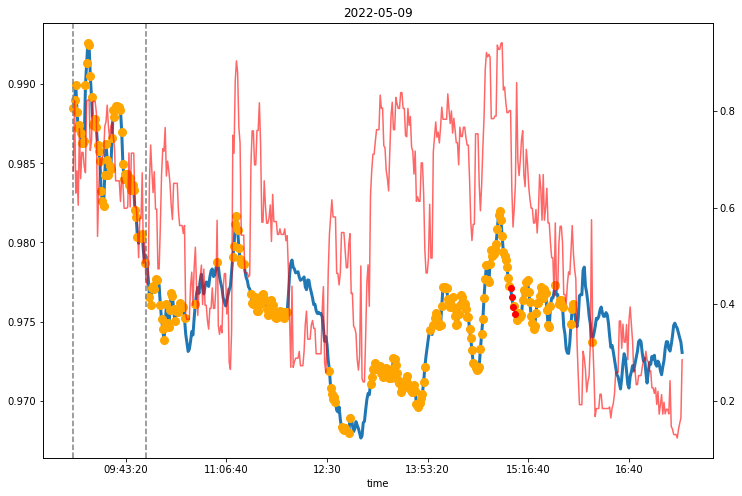

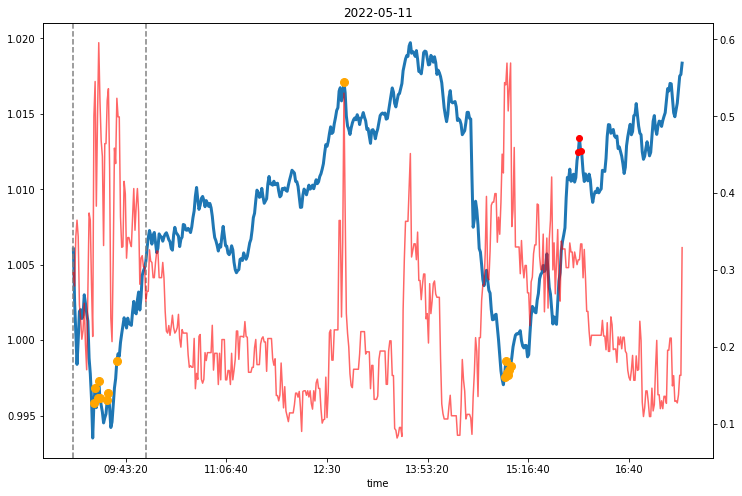

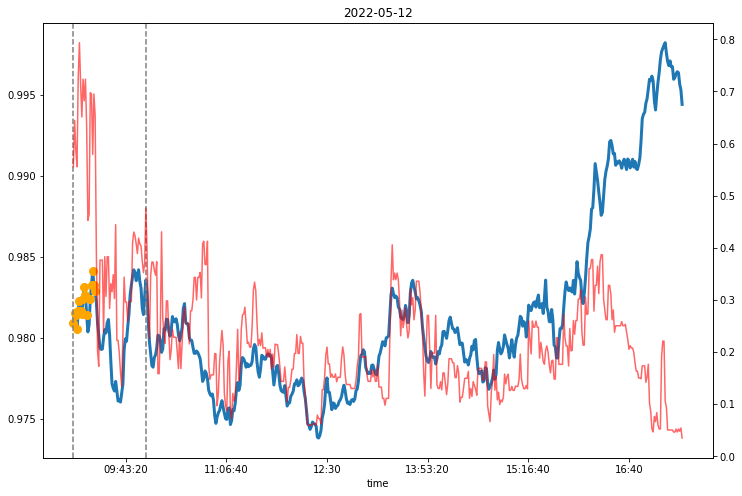

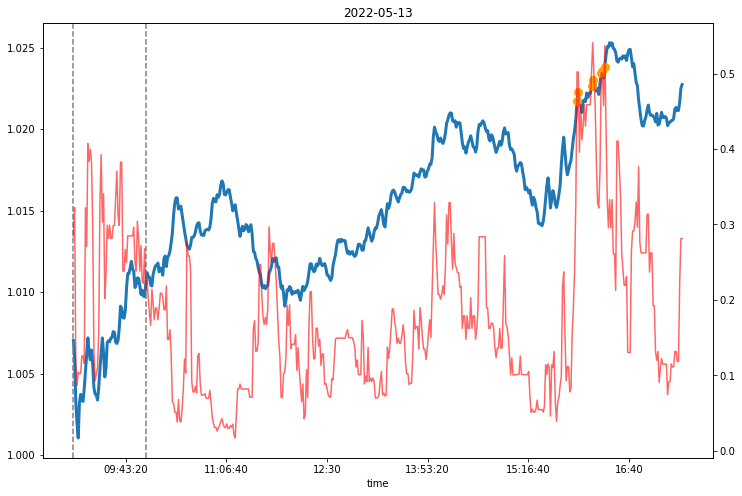

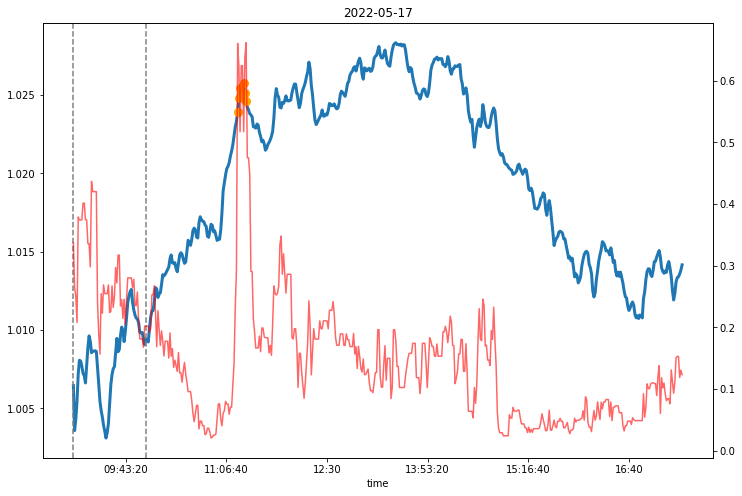

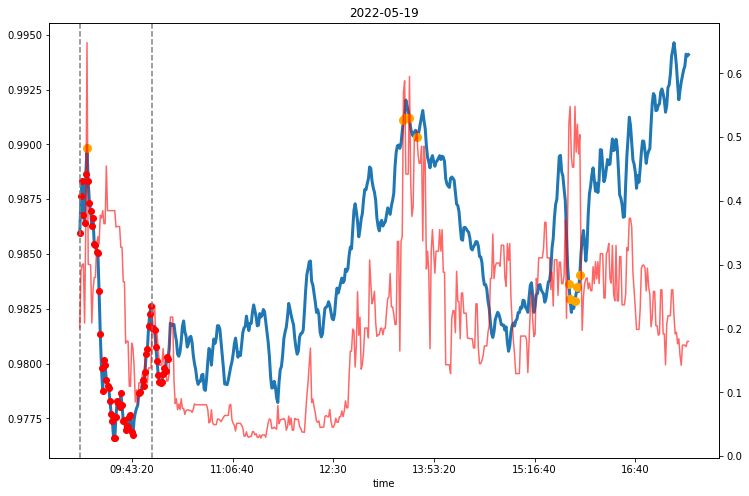

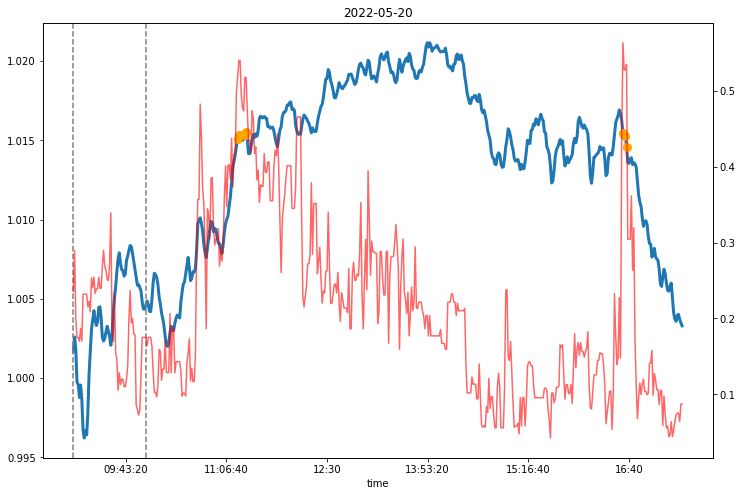

In [56]:
dates = df[(df['action']==1) & (df['date']>='2022-04-01') & (df['date']<'2022-07-01')]['date'].sort_values().unique()
print(len(dates))
#random_date = np.random.choice(dates, 10, replace = False)
#random_date = df[df['new_day']==0].groupby('date')['return'].prod().sort_values().tail(20).index
#random_date = df.groupby('date')[['price']].agg(['min', 'max']).pct_change(axis =1).sort_values(by=('price', 'max')).tail(20).index
#random_date = df[df['action']==1].groupby('date')['return'].prod().sort_values(ascending=False).index


for day in dates[0:20]:
    f, ax = plt.subplots(figsize= (12, 8))
    
    hour = 8
    
    df_filt = df[(df['date']==day) & (df['hour']>hour)]

    df_cum = df_filt.set_index('time')['return'].cumprod()
    df_cum.plot(title=f'{day}'[:10],ax=ax, lw=3, alpha = 1)
    #df[(df['date']==day)].set_index('time')['return_10min_avg'].plot(ax=ax, lw=2)
    #df[(df['date']==day)].set_index('time')['return_20min_avg'].plot(ax=ax, lw=2)
    #df[(df['date']==day)].set_index('time')['return_30min_avg'].plot(ax=ax, lw=2)
    
    
    df_cum.loc[df[(df['date']==day) & (df['hour']>hour) & (df['action']==1)]['time'].values].plot(ax=ax, ls='', marker='o', ms=8, color='orange', alpha=1)
    df_cum.loc[df[(df['date']==day) & (df['hour']>hour) & (df['action']==-1)]['time'].values].plot(ax=ax, ls='', marker='o', color='r', alpha=1)
    
    ax2 = ax.twinx()
    df_filt.set_index('time')['pred_price_pct_up'].plot(ax=ax2, color ='r', alpha = 0.6)
    #df[(df['action']==1) & (df['date']==day) & (df['hour']>hour)].set_index('time')['return'].cumprod().plot(ax=ax2)
    #df_cum.loc[df[df['return_10min']==1.002]['datetime'].values].plot(ax=ax, ls='', marker='o')
    ax.axvline('09:00', color='grey', ls='--')
    ax.axvline('10:00', color='grey', ls='--')
    #ax2.axvline('11:00', color='grey', ls='--')
    #ax2.axhline(1, color='grey', ls='--')
    

<AxesSubplot:xlabel='time'>

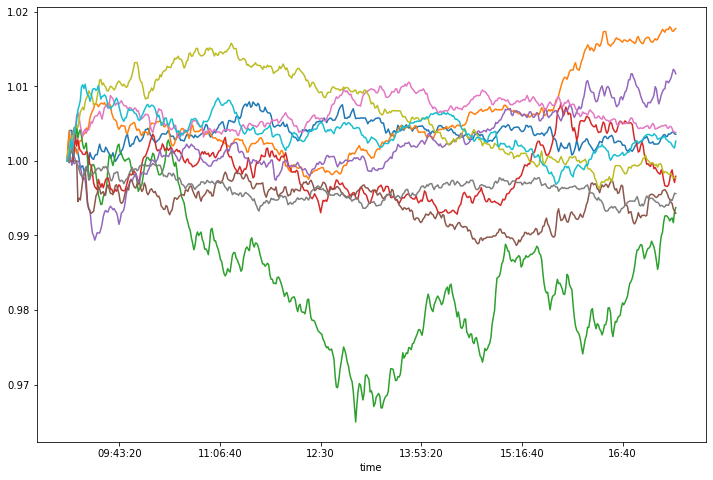

In [316]:
f, ax = plt.subplots(figsize= (12, 8))

dates = df['date'].unique()
random_date = np.random.choice(dates, 10, replace = False)
df_cell = df[df['date'].isin(random_date)].set_index(['date','time'])['price'].unstack(level=0)

df_cell.div(df_cell.iloc[0,:]).plot(ax=ax, legend = False)

In [321]:


df['price_fft'] = df['price'].apply(np.fft.fft)

df['price_fft'].plot()

IndexError: tuple index out of range

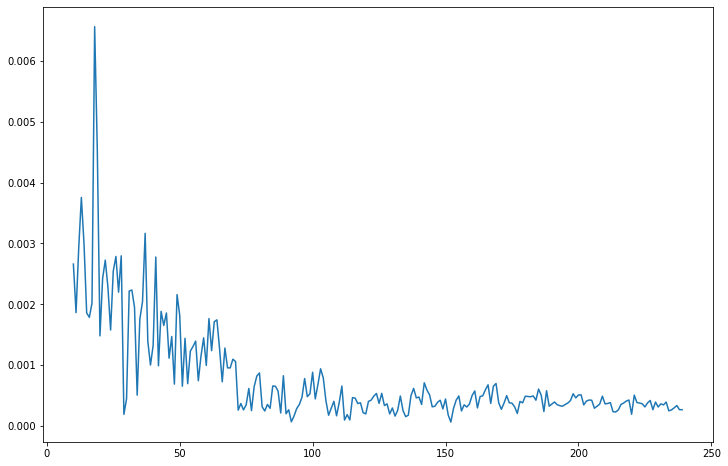

In [486]:
avg_daily = df.set_index(['date', 'time'])['return_cumday'].sub(1).unstack(level=0).dropna()

avg_daily_fft  = avg_daily.apply(np.fft.rfft).mean(axis=1)#.apply(np.fft.irfft)
avg_daily_fft_std  = avg_daily.apply(np.fft.rfft).std(axis =1)

min_range = np.arange(10,240,1) 
min_components = avg_daily_fft.values[min_range]
min_components_std = avg_daily_fft_std.values[min_range]

f, ax = plt.subplots(figsize= (12, 8))
ax.plot(min_range, abs(min_components))
#ax.plot(min_range, min_components+min_components_std)
#ax.plot(min_range, min_components-min_components_std)

C:\Users\ohjartarson\Anaconda3\lib\site-packages\pandas\core\window\rolling.py:355: ComplexWarning: Casting complex values to real discards the imaginary part
  values = ensure_float64(values)


<AxesSubplot:xlabel='date'>

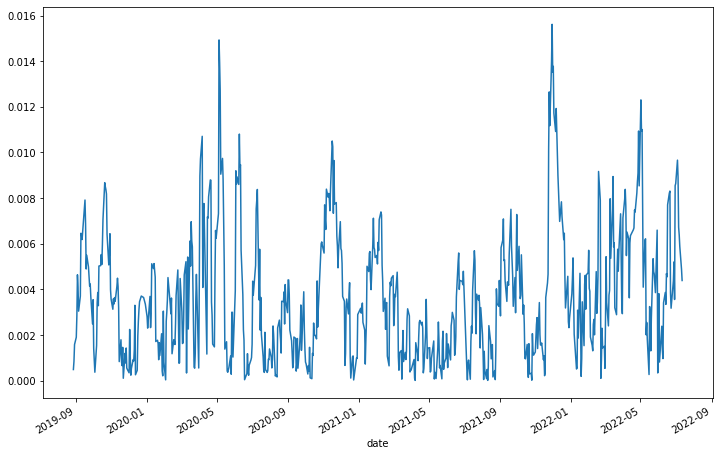

In [485]:
f, ax = plt.subplots(figsize= (12, 8))

minute = 30

avg_daily_rol = avg_daily.apply(np.fft.rfft).iloc[minute, :].rolling(20).mean()
avg_daily_rol_std = avg_daily.apply(np.fft.rfft).iloc[minute, :].rolling(20).std()

avg_daily_rol.abs().plot(ax=ax)
#avg_daily_rol.add(avg_daily_rol_std).plot(ax=ax)
#avg_daily_rol.sub(avg_daily_rol_std).plot(ax=ax)

In [465]:
avg_daily.apply(np.fft.rfft)

0      4.434018
1      1.218008
2      0.678514
3      0.453790
4      0.342052
         ...   
248    0.006668
249    0.006811
250    0.006764
251    0.006834
252    0.006759
Length: 253, dtype: float64

In [423]:
import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq

signal = df['return_cumday'].sub(1).dropna()

W = fftfreq(signal.size, d=1)

f_signal = rfft(signal)
cut_f_signal = f_signal.copy()
cut_f_signal[(W>0.001)] = 0

cut_signal = irfft(cut_f_signal)

f, ax = plt.subplots(figsize= (12, 8))
ax.plot(f_signal)
#ax2 = ax.twinx()
#ax2.plot(cut_signal, ls='--', color='red')

W

AttributeError: 'Series' object has no attribute 'flags'

In [415]:
df['return_cumday'].sub(1)#.plot()

0              NaN
1         0.000000
2         0.000553
3         0.001316
4         0.002844
            ...   
374200    0.022812
374201    0.022695
374202    0.022951
374203    0.023479
374204    0.024155
Name: return_cumday, Length: 374205, dtype: float64

In [386]:
W.max()

0.49999732236574346

In [379]:


time   = np.linspace(0,10,2000)
signal = np.cos(5*np.pi*time) + np.cos(7*np.pi*time)

W = fftfreq(signal.size, d=signal.index[1]-signal.index[0])

W = fftfreq(signal.size, d=time[1]-time[0])
f_signal = rfft(signal)

# If our original signal time was in seconds, this is now in Hz    
cut_f_signal = f_signal.copy()
cut_f_signal[(W<6)] = 0

cut_signal = irfft(f_signal)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

#### BUY LOGIC

In [8]:
from datetime import time

df['fika_entry'] = df['price'].shift(45)
df['fika_entry'] = df['price'].div(df['fika_entry'])

df.loc[(df['time']!=time(10, 0)), 'fika_entry'] = np.nan
df.loc[(df['time']==time(10, 0)) & (df['fika_entry']<=1), 'fika_entry'] = np.nan
df.loc[(df['time']==time(10, 0)) & (df['fika_entry']>1), 'fika_entry'] = df['price']

#df['fika_entry'] = df['fika_entry'].shift(1)

df = df.set_index(['date','time'])
df['fika_entry'] = df['fika_entry'].unstack().ffill(axis=1).shift(1, axis=1).stack()
df = df.reset_index()

df.loc[~df['fika_entry'].isna(),'fika_price'] = df['price']
df.loc[~df['fika_entry'].isna(),'fika_buy'] = 1

df.head(70).tail(20)

date      time       price            datetime  year  month  day  \
50 2019-08-01  09:50:00  115.386750 2019-08-01 09:50:00  2019      8    1   
51 2019-08-01  09:51:00  115.418750 2019-08-01 09:51:00  2019      8    1   
52 2019-08-01  09:52:00  115.469937 2019-08-01 09:52:00  2019      8    1   
53 2019-08-01  09:53:00  115.432375 2019-08-01 09:53:00  2019      8    1   
54 2019-08-01  09:54:00  115.393125 2019-08-01 09:54:00  2019      8    1   
55 2019-08-01  09:55:00  115.433188 2019-08-01 09:55:00  2019      8    1   
56 2019-08-01  09:56:00  115.462563 2019-08-01 09:56:00  2019      8    1   
57 2019-08-01  09:57:00  115.438000 2019-08-01 09:57:00  2019      8    1   
58 2019-08-01  09:58:00  115.468687 2019-08-01 09:58:00  2019      8    1   
59 2019-08-01  09:59:00  115.530000 2019-08-01 09:59:00  2019      8    1   
60 2019-08-01  10:00:00  115.545000 2019-08-01 10:00:00  2019      8    1   
61 2019-08-01  10:01:00  115.574500 2019-08-01 10:01:00  2019      8    1   
62 2019-08-01  10:02:00  115.605625 2019-08-01 10:02:00  2019      8    1   
63 2019-08-01  10:03:00  115.625687 2019-08-01 10:03:00  2019      8    1   
64 2019-08-01  10:04:00  115.574500 2019-08-01 10:04:00  2019      8    1   
65 2019-08-01  10:05:00  115.525000 2019-08-01 10:05:00  2019      8    1   
66 2019-08-01  10:06:00  115.507563 2019-08-01 10:06:00  2019      8    1   
67 2019-08-01  10:07:00  115.475625 2019-08-01 10:07:00  2019      8    1   
68 2019-08-01  10:08:00  115.430688 2019-08-01 10:08:00  2019      8    1   
69 2019-08-01  10:09:00  115.394437 2019-08-01 10:09:00  2019      8    1   

     datetime_diff  hour_gap  new_day    return  return_new_day  fika_entry  \
50 0 days 00:01:00  0.016667        0  0.999127             NaN         NaN   
51 0 days 00:01:00  0.016667        0  1.000277             NaN         NaN   
52 0 days 00:01:00  0.016667        0  1.000443             NaN         NaN   
53 0 days 00:01:00  0.016667        0  0.999675             NaN         NaN   
54 0 days 00:01:00  0.016667        0  0.999660             NaN         NaN   
55 0 days 00:01:00  0.016667        0  1.000347             NaN         NaN   
56 0 days 00:01:00  0.016667        0  1.000254             NaN         NaN   
57 0 days 00:01:00  0.016667        0  0.999787             NaN         NaN   
58 0 days 00:01:00  0.016667        0  1.000266             NaN         NaN   
59 0 days 00:01:00  0.016667        0  1.000531             NaN         NaN   
60 0 days 00:01:00  0.016667        0  1.000130             NaN         NaN   
61 0 days 00:01:00  0.016667        0  1.000255             NaN     115.545   
62 0 days 00:01:00  0.016667        0  1.000269             NaN     115.545   
63 0 days 00:01:00  0.016667        0  1.000174             NaN     115.545   
64 0 days 00:01:00  0.016667        0  0.999557             NaN     115.545   
65 0 days 00:01:00  0.016667        0  0.999572             NaN     115.545   
66 0 days 00:01:00  0.016667        0  0.999849             NaN     115.545   
67 0 days 00:01:00  0.016667        0  0.999724             NaN     115.545   
68 0 days 00:01:00  0.016667        0  0.999611             NaN     115.545   
69 0 days 00:01:00  0.016667        0  0.999686             NaN     115.545   

    fika_price  fika_buy  
50         NaN       NaN  
51         NaN       NaN  
52         NaN       NaN  
53         NaN       NaN  
54         NaN       NaN  
55         NaN       NaN  
56         NaN       NaN  
57         NaN       NaN  
58         NaN       NaN  
59         NaN       NaN  
60         NaN       NaN  
61  115.574500       1.0  
62  115.605625       1.0  
63  115.625687       1.0  
64  115.574500       1.0  
65  115.525000       1.0  
66  115.507563       1.0  
67  115.475625       1.0  
68  115.430688       1.0  
69  115.394437       1.0

In [9]:
df = df.set_index(['date','time'])
df['fika_max'] = df['fika_price'].unstack().cummax(axis=1).stack()
df = df.reset_index()

df.head(70).tail(20)

date      time       price            datetime  year  month  day  \
50 2019-08-01  09:50:00  115.386750 2019-08-01 09:50:00  2019      8    1   
51 2019-08-01  09:51:00  115.418750 2019-08-01 09:51:00  2019      8    1   
52 2019-08-01  09:52:00  115.469937 2019-08-01 09:52:00  2019      8    1   
53 2019-08-01  09:53:00  115.432375 2019-08-01 09:53:00  2019      8    1   
54 2019-08-01  09:54:00  115.393125 2019-08-01 09:54:00  2019      8    1   
55 2019-08-01  09:55:00  115.433188 2019-08-01 09:55:00  2019      8    1   
56 2019-08-01  09:56:00  115.462563 2019-08-01 09:56:00  2019      8    1   
57 2019-08-01  09:57:00  115.438000 2019-08-01 09:57:00  2019      8    1   
58 2019-08-01  09:58:00  115.468687 2019-08-01 09:58:00  2019      8    1   
59 2019-08-01  09:59:00  115.530000 2019-08-01 09:59:00  2019      8    1   
60 2019-08-01  10:00:00  115.545000 2019-08-01 10:00:00  2019      8    1   
61 2019-08-01  10:01:00  115.574500 2019-08-01 10:01:00  2019      8    1   
62 2019-08-01  10:02:00  115.605625 2019-08-01 10:02:00  2019      8    1   
63 2019-08-01  10:03:00  115.625687 2019-08-01 10:03:00  2019      8    1   
64 2019-08-01  10:04:00  115.574500 2019-08-01 10:04:00  2019      8    1   
65 2019-08-01  10:05:00  115.525000 2019-08-01 10:05:00  2019      8    1   
66 2019-08-01  10:06:00  115.507563 2019-08-01 10:06:00  2019      8    1   
67 2019-08-01  10:07:00  115.475625 2019-08-01 10:07:00  2019      8    1   
68 2019-08-01  10:08:00  115.430688 2019-08-01 10:08:00  2019      8    1   
69 2019-08-01  10:09:00  115.394437 2019-08-01 10:09:00  2019      8    1   

     datetime_diff  hour_gap  new_day    return  return_new_day  fika_entry  \
50 0 days 00:01:00  0.016667        0  0.999127             NaN         NaN   
51 0 days 00:01:00  0.016667        0  1.000277             NaN         NaN   
52 0 days 00:01:00  0.016667        0  1.000443             NaN         NaN   
53 0 days 00:01:00  0.016667        0  0.999675             NaN         NaN   
54 0 days 00:01:00  0.016667        0  0.999660             NaN         NaN   
55 0 days 00:01:00  0.016667        0  1.000347             NaN         NaN   
56 0 days 00:01:00  0.016667        0  1.000254             NaN         NaN   
57 0 days 00:01:00  0.016667        0  0.999787             NaN         NaN   
58 0 days 00:01:00  0.016667        0  1.000266             NaN         NaN   
59 0 days 00:01:00  0.016667        0  1.000531             NaN         NaN   
60 0 days 00:01:00  0.016667        0  1.000130             NaN         NaN   
61 0 days 00:01:00  0.016667        0  1.000255             NaN     115.545   
62 0 days 00:01:00  0.016667        0  1.000269             NaN     115.545   
63 0 days 00:01:00  0.016667        0  1.000174             NaN     115.545   
64 0 days 00:01:00  0.016667        0  0.999557             NaN     115.545   
65 0 days 00:01:00  0.016667        0  0.999572             NaN     115.545   
66 0 days 00:01:00  0.016667        0  0.999849             NaN     115.545   
67 0 days 00:01:00  0.016667        0  0.999724             NaN     115.545   
68 0 days 00:01:00  0.016667        0  0.999611             NaN     115.545   
69 0 days 00:01:00  0.016667        0  0.999686             NaN     115.545   

    fika_price  fika_buy    fika_max  
50         NaN       NaN         NaN  
51         NaN       NaN         NaN  
52         NaN       NaN         NaN  
53         NaN       NaN         NaN  
54         NaN       NaN         NaN  
55         NaN       NaN         NaN  
56         NaN       NaN         NaN  
57         NaN       NaN         NaN  
58         NaN       NaN         NaN  
59         NaN       NaN         NaN  
60         NaN       NaN         NaN  
61  115.574500       1.0  115.574500  
62  115.605625       1.0  115.605625  
63  115.625687       1.0  115.625687  
64  115.574500       1.0  115.625687  
65  115.525000       1.0  115.625687  
66  115.507563       1.0  115.625687  
67  115.475625       1.0  115

In [10]:
# SELL LOGIC, 
df['fika_sell'] = np.nan
df.loc[(df['fika_price'] < df['fika_max']*0.995),'fika_sell'] = 1

df = df.set_index(['date','time'])
df['fika_sell'] = df['fika_sell'].unstack().ffill(axis=1).stack()
df = df.reset_index()

In [11]:
df['fika_hold'] = np.nan

df.loc[(df['fika_buy']==1) & (df['fika_sell'].isna()), 'fika_hold'] = 1
df['fika_hold'] = df['fika_hold']#.shift(1)
df.head(70).tail(20)

date      time       price            datetime  year  month  day  \
50 2019-08-01  09:50:00  115.386750 2019-08-01 09:50:00  2019      8    1   
51 2019-08-01  09:51:00  115.418750 2019-08-01 09:51:00  2019      8    1   
52 2019-08-01  09:52:00  115.469937 2019-08-01 09:52:00  2019      8    1   
53 2019-08-01  09:53:00  115.432375 2019-08-01 09:53:00  2019      8    1   
54 2019-08-01  09:54:00  115.393125 2019-08-01 09:54:00  2019      8    1   
55 2019-08-01  09:55:00  115.433188 2019-08-01 09:55:00  2019      8    1   
56 2019-08-01  09:56:00  115.462563 2019-08-01 09:56:00  2019      8    1   
57 2019-08-01  09:57:00  115.438000 2019-08-01 09:57:00  2019      8    1   
58 2019-08-01  09:58:00  115.468687 2019-08-01 09:58:00  2019      8    1   
59 2019-08-01  09:59:00  115.530000 2019-08-01 09:59:00  2019      8    1   
60 2019-08-01  10:00:00  115.545000 2019-08-01 10:00:00  2019      8    1   
61 2019-08-01  10:01:00  115.574500 2019-08-01 10:01:00  2019      8    1   
62 2019-08-01  10:02:00  115.605625 2019-08-01 10:02:00  2019      8    1   
63 2019-08-01  10:03:00  115.625687 2019-08-01 10:03:00  2019      8    1   
64 2019-08-01  10:04:00  115.574500 2019-08-01 10:04:00  2019      8    1   
65 2019-08-01  10:05:00  115.525000 2019-08-01 10:05:00  2019      8    1   
66 2019-08-01  10:06:00  115.507563 2019-08-01 10:06:00  2019      8    1   
67 2019-08-01  10:07:00  115.475625 2019-08-01 10:07:00  2019      8    1   
68 2019-08-01  10:08:00  115.430688 2019-08-01 10:08:00  2019      8    1   
69 2019-08-01  10:09:00  115.394437 2019-08-01 10:09:00  2019      8    1   

     datetime_diff  hour_gap  new_day    return  return_new_day  fika_entry  \
50 0 days 00:01:00  0.016667        0  0.999127             NaN         NaN   
51 0 days 00:01:00  0.016667        0  1.000277             NaN         NaN   
52 0 days 00:01:00  0.016667        0  1.000443             NaN         NaN   
53 0 days 00:01:00  0.016667        0  0.999675             NaN         NaN   
54 0 days 00:01:00  0.016667        0  0.999660             NaN         NaN   
55 0 days 00:01:00  0.016667        0  1.000347             NaN         NaN   
56 0 days 00:01:00  0.016667        0  1.000254             NaN         NaN   
57 0 days 00:01:00  0.016667        0  0.999787             NaN         NaN   
58 0 days 00:01:00  0.016667        0  1.000266             NaN         NaN   
59 0 days 00:01:00  0.016667        0  1.000531             NaN         NaN   
60 0 days 00:01:00  0.016667        0  1.000130             NaN         NaN   
61 0 days 00:01:00  0.016667        0  1.000255             NaN     115.545   
62 0 days 00:01:00  0.016667        0  1.000269             NaN     115.545   
63 0 days 00:01:00  0.016667        0  1.000174             NaN     115.545   
64 0 days 00:01:00  0.016667        0  0.999557             NaN     115.545   
65 0 days 00:01:00  0.016667        0  0.999572             NaN     115.545   
66 0 days 00:01:00  0.016667        0  0.999849             NaN     115.545   
67 0 days 00:01:00  0.016667        0  0.999724             NaN     115.545   
68 0 days 00:01:00  0.016667        0  0.999611             NaN     115.545   
69 0 days 00:01:00  0.016667        0  0.999686             NaN     115.545   

    fika_price  fika_buy    fika_max  fika_sell  fika_hold  
50         NaN       NaN         NaN        NaN        NaN  
51         NaN       NaN         NaN        NaN        NaN  
52         NaN       NaN         NaN        NaN        NaN  
53         NaN       NaN         NaN        NaN        NaN  
54         NaN       NaN         NaN        NaN        NaN  
55         NaN       NaN         NaN        NaN        NaN  
56         NaN       NaN         NaN        NaN        NaN  
57         NaN       NaN         NaN        NaN        NaN  
58         NaN       NaN         NaN        NaN        NaN  
59         NaN       NaN         NaN        NaN        NaN  
60         NaN       NaN         NaN        NaN        NaN  

In [12]:
df.loc[df['fika_hold']==1].set_index('datetime')['return'].cumprod()

datetime
2019-08-01 10:01:00    1.000255
2019-08-01 10:02:00    1.000525
2019-08-01 10:03:00    1.000698
2019-08-01 10:04:00    1.000255
2019-08-01 10:05:00    0.999827
                         ...   
2022-07-08 11:03:00    1.398352
2022-07-08 11:04:00    1.398147
2022-07-08 11:05:00    1.397528
2022-07-08 11:06:00    1.397353
2022-07-08 11:07:00    1.396396
Name: return, Length: 76724, dtype: float64

<AxesSubplot:xlabel='datetime'>

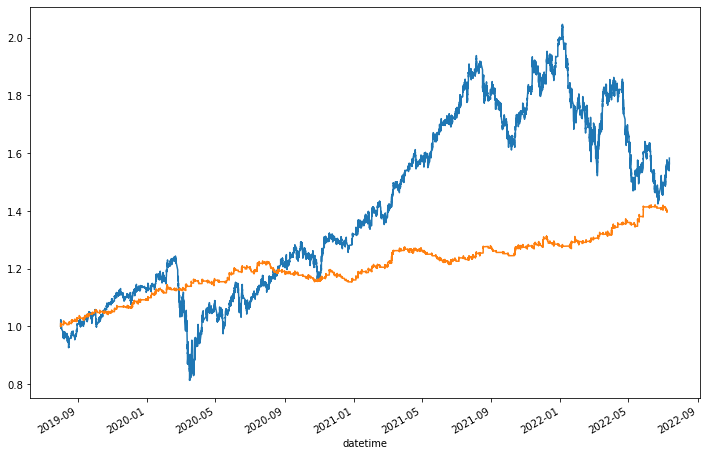

In [13]:
f, ax = plt.subplots(figsize= (12, 8))
df.set_index('datetime')['return'].cumprod().plot(ax=ax)
df.loc[df['fika_hold']==1].set_index('datetime')['return'].cumprod().plot(ax=ax)
#df[df['datetime'].isin()]

In [1011]:
dates = df[df['fika_hold']==1]['date'].unique()
df.loc[(df['date'].isin(dates))].groupby('date')['return'].prod().sort_values().tail(10)

date
2022-03-29    1.051508
2020-04-29    1.056541
2020-05-27    1.058997
2020-06-05    1.069040
2020-04-07    1.069141
2020-03-19    1.070315
2020-01-30    1.088176
2020-04-06    1.088217
2020-03-25    1.097875
2020-03-24    1.113371
Name: return, dtype: float64

237350    1.001772
Name: return, dtype: float64
220685    1.001368
Name: return, dtype: float64
249470    1.003081
Name: return, dtype: float64
284820    0.999858
Name: return, dtype: float64
57065    0.998599
Name: return, dtype: float64
337845    1.003138
Name: return, dtype: float64
208060    0.993823
Name: return, dtype: float64
355520    1.003533
Name: return, dtype: float64
308555    1.005362
Name: return, dtype: float64
69185    0.994829
Name: return, dtype: float64


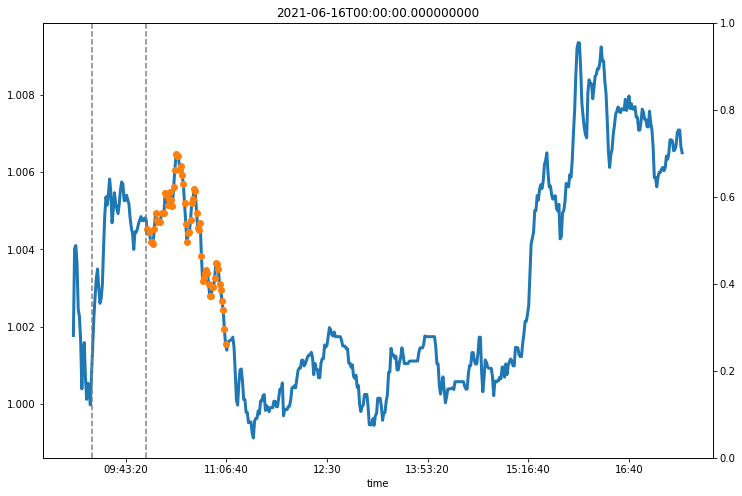

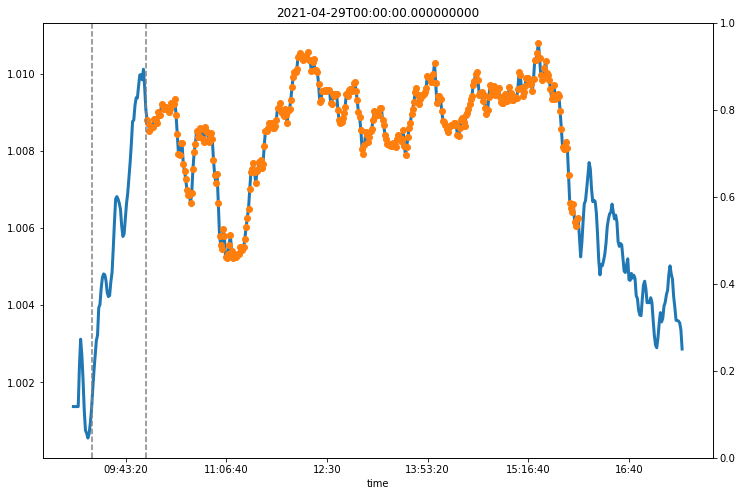

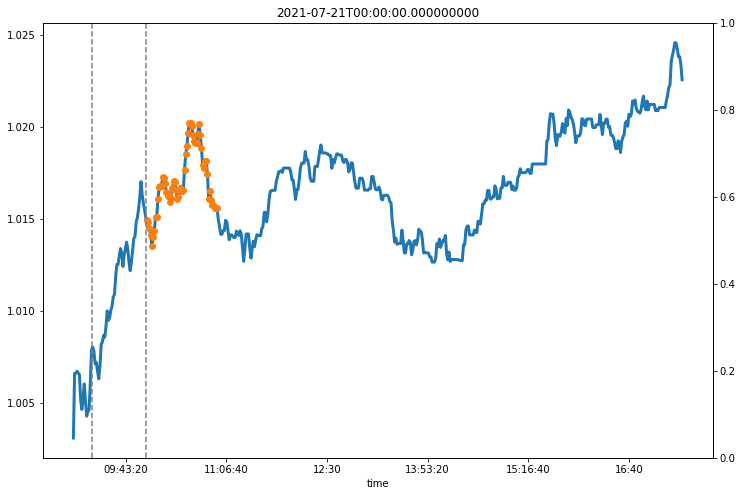

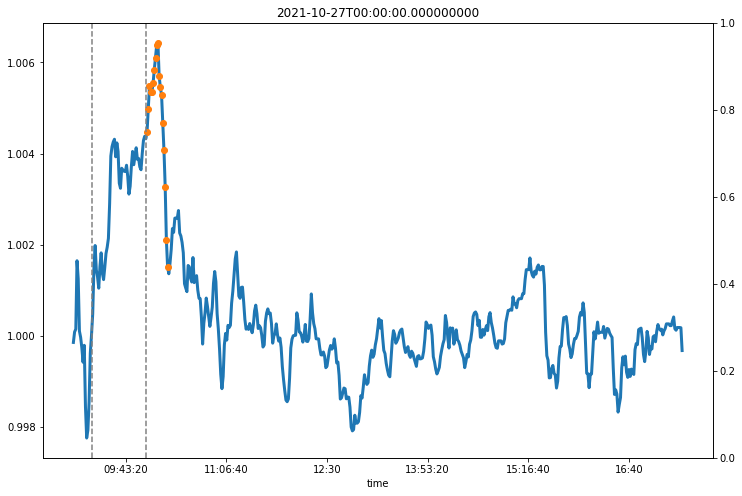

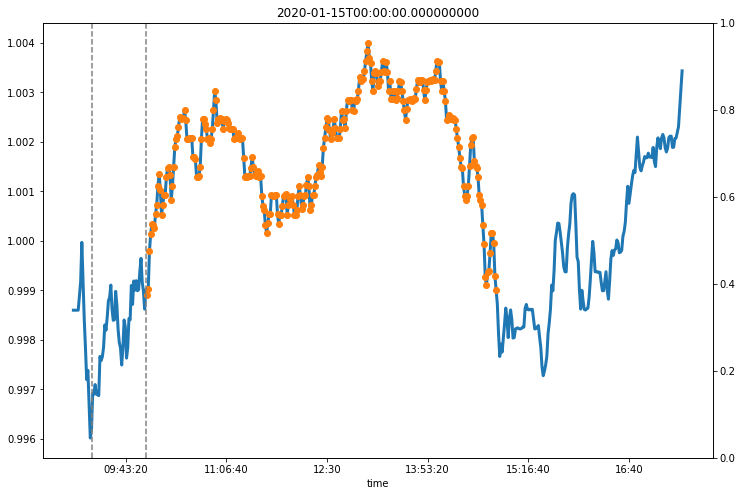

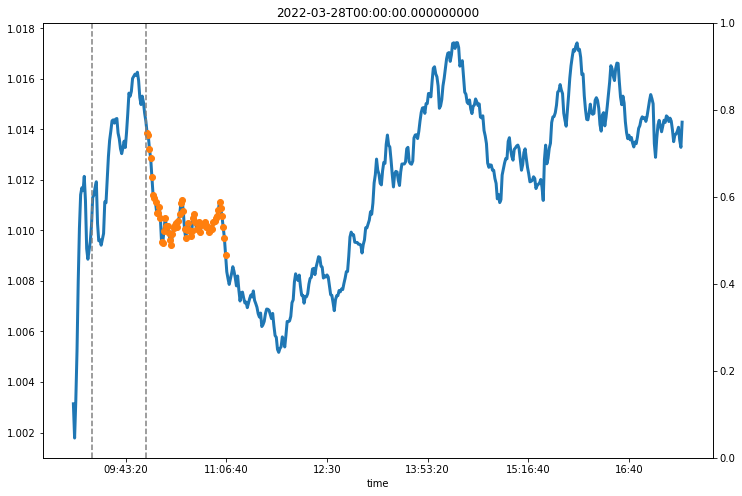

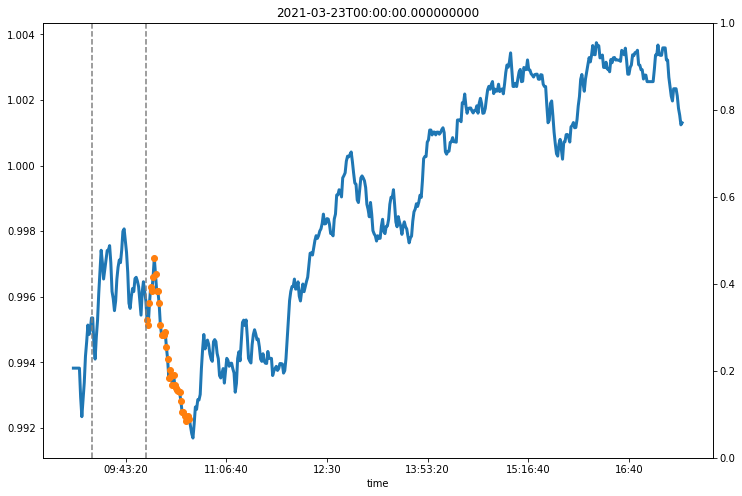

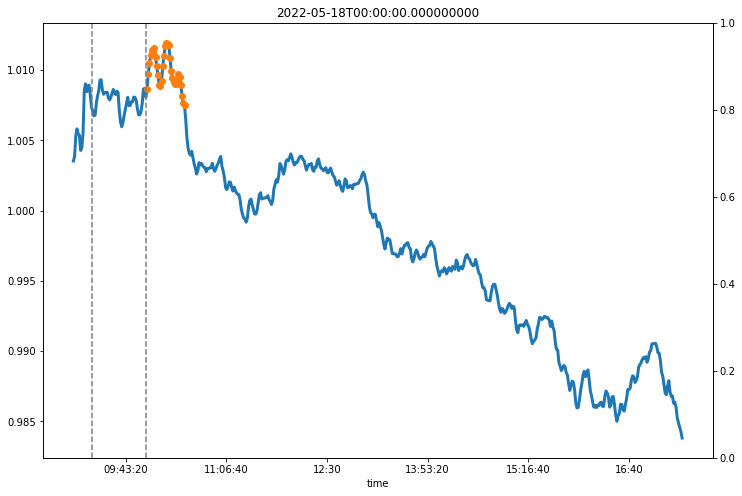

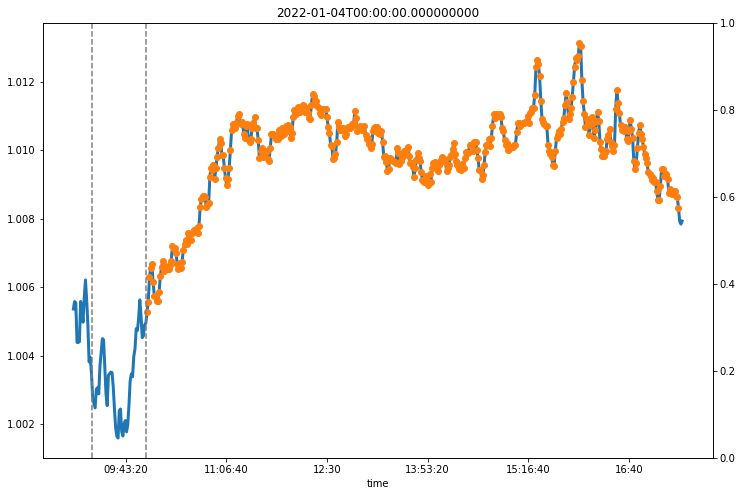

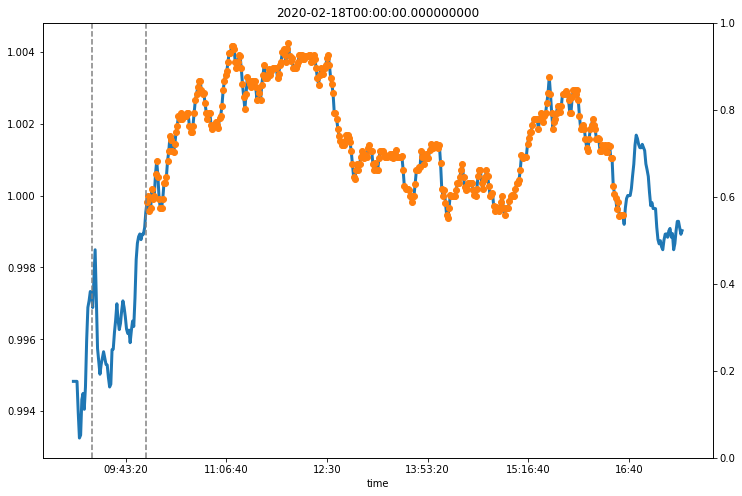

In [14]:
dates = df[df['fika_hold']==1]['date'].unique()
random_date = df.loc[(df['date'].isin(dates))].groupby('date')['return'].prod().sort_values().tail(10).index
random_date = np.random.choice(dates, 20)

for day in random_date[:10]:
    random_date = day
    print(df[(df['date']==random_date) & (df['new_day']==1)]['return'])
    #gap = df[(df['date']==random_date) & (df['new_day']==1)].iloc[0]['return']
    f, ax = plt.subplots(figsize= (12, 8))
        
    df_cum = df[(df['date']==random_date)].set_index('time')['return'].cumprod()
    df_cum.plot(title=str(random_date),ax=ax, lw=3)
    df_cum.loc[df[(df['date']==random_date) & (df['fika_hold']==1)]['time'].values].plot(ax=ax, ls='', marker='o')
    #df_cum.loc[df[df['return_10min']==1.002]['datetime'].values].plot(ax=ax, ls='', marker='o')
    ax2 = ax.twinx()

    #df[(df['date']==random_date) & (df['return_10min']==1.002)].set_index('time')['return'].cumprod().plot(ax=ax, color='r', ls='', marker='o')
    #df[df['date']==random_date].set_index('time')['pct_change'].rolling(10).agg(lambda x : x.prod()).plot(ax=ax2, color='orange')
    #df[(df['date']==random_date)].set_index('time')['volume'].rolling(10).mean().plot(ax=ax2, color='r')
    #ax2.set(zorder=99)
    #ax2.axhline(0, color='grey', ls='--')
    ax.axvline('10:00', color='grey', ls='--')
    #ax2.axvline('11:00', color='grey', ls='--')
    ax.axvline('09:15', color='grey', ls='--')

In [990]:
df.groupby('new_day')['return'].prod()

new_day
0    1.174989
1    0.665986
Name: return, dtype: float64

In [546]:
df[(df['date']==random_date)].iloc[0]['pct_change']

1.0175487633219384

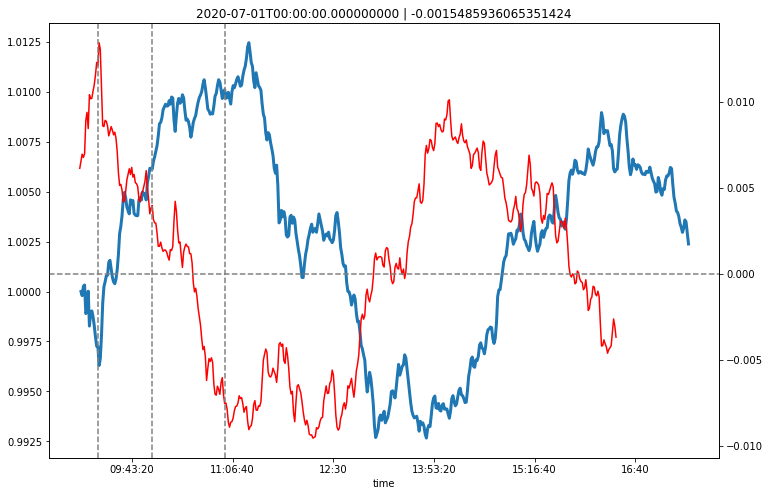

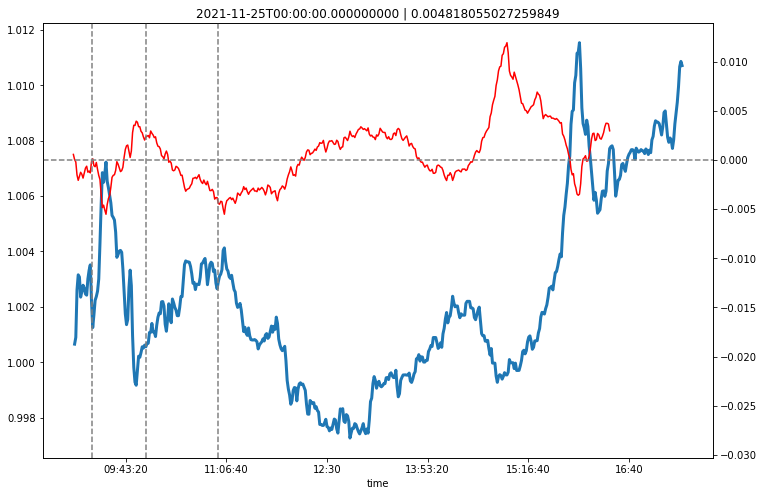

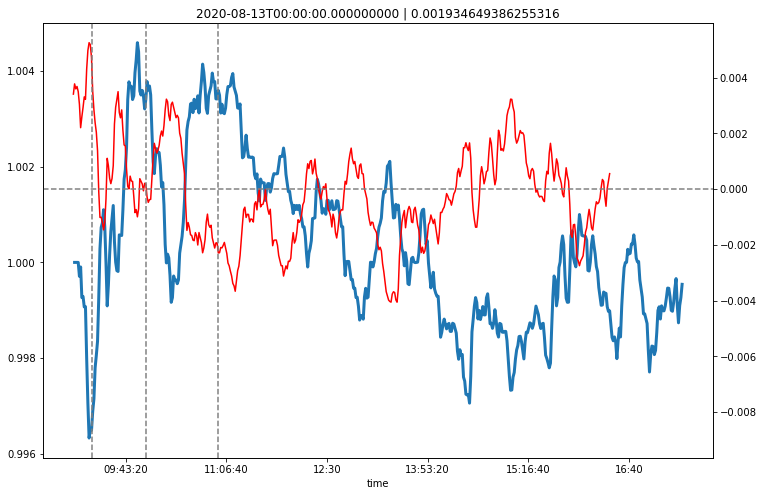

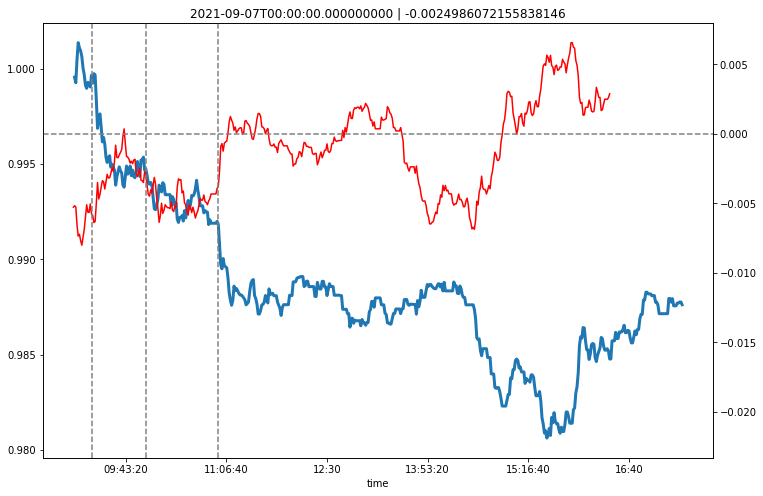

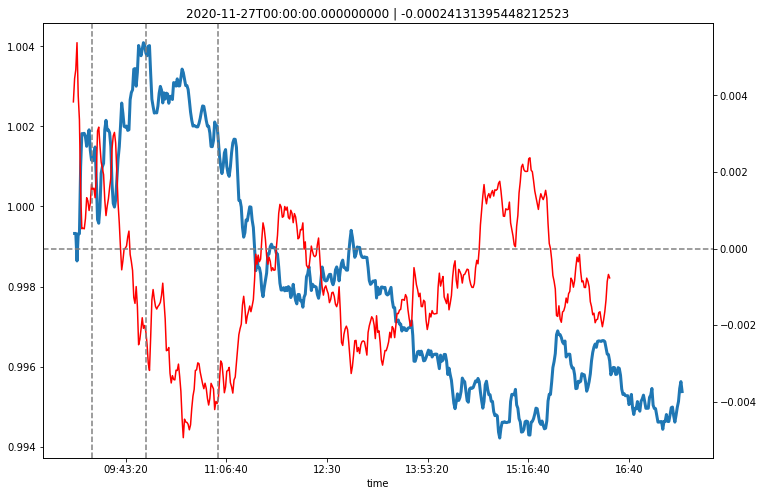

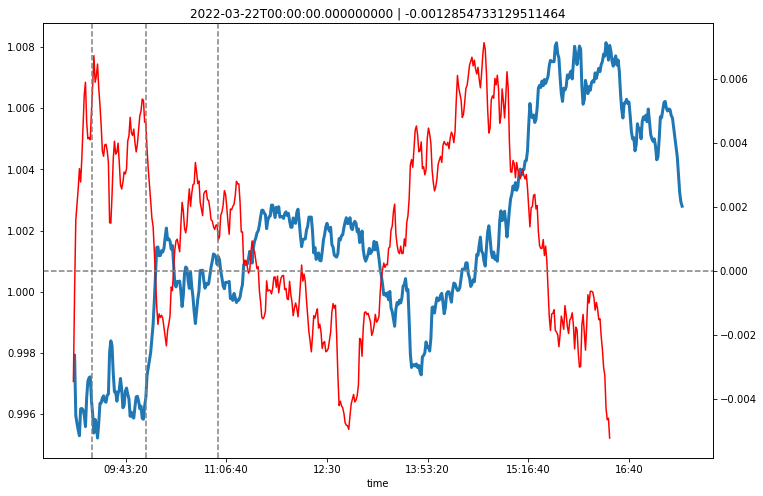

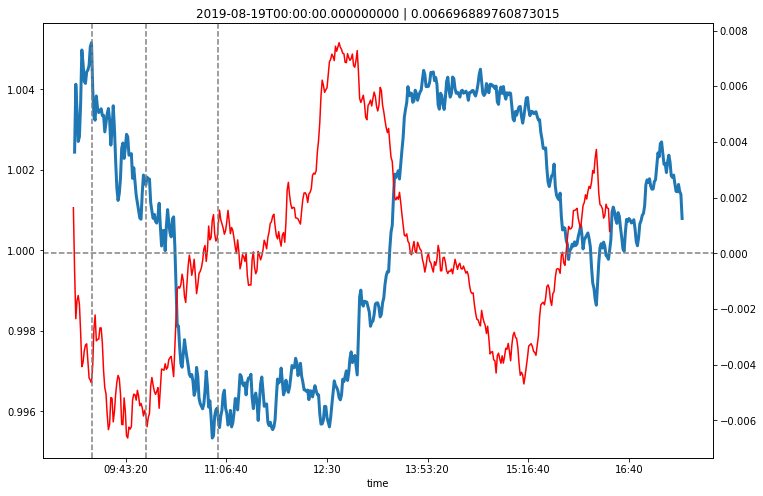

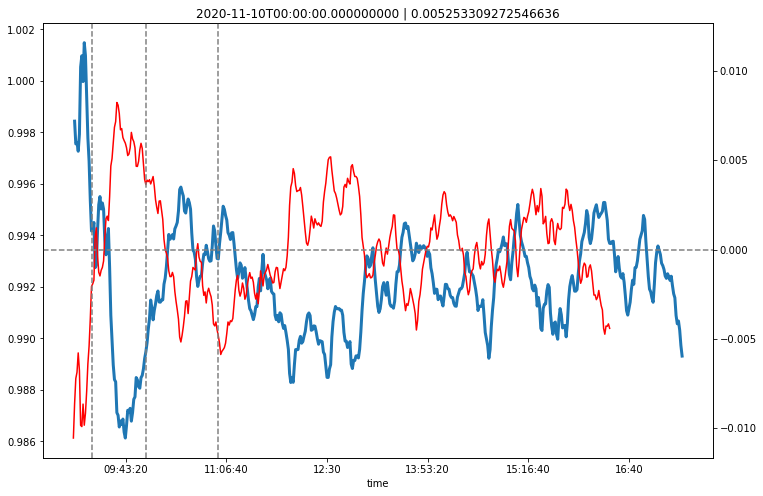

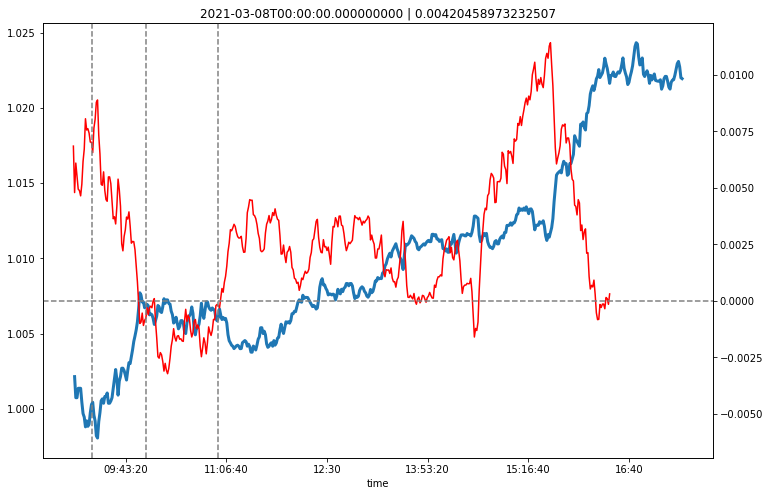

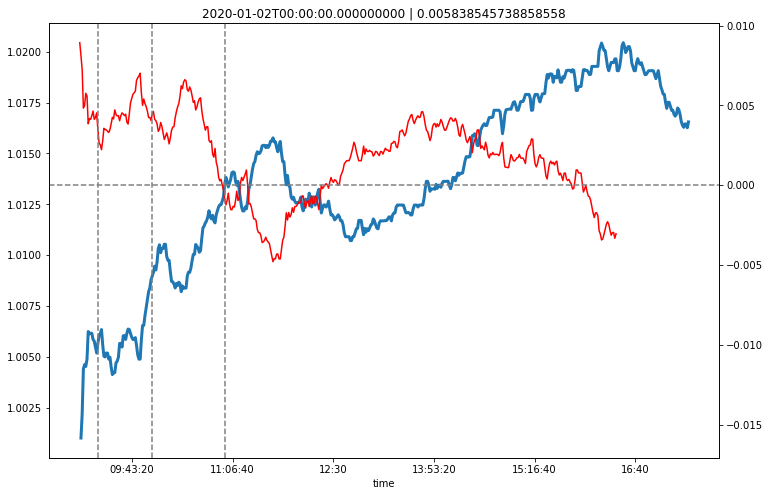

In [655]:

random_date = np.random.choice(df['date'].unique(), 10)

for day in random_date:
    random_date = day
    gap = df[(df['date']==random_date) & (df['new_day']==1)].iloc[0]['return']
    f, ax = plt.subplots(figsize= (12, 8))
    df[(df['date']==random_date) & (df['new_day']==0)].set_index('time')['return'].add(1).cumprod().plot(title=str(random_date)+' | '+str(gap),ax=ax, lw=3)
    ax2 = ax.twinx()

    df[df['date']==random_date].set_index('time')['return_60min'].plot(ax=ax2, color='r')
    #df[df['date']==random_date].set_index('time')['pct_change'].rolling(10).agg(lambda x : x.prod()).plot(ax=ax2, color='orange')
    #df[(df['date']==random_date)].set_index('time')['volume'].rolling(10).mean().plot(ax=ax2, color='r')
    #ax2.set(zorder=99)
    ax2.axhline(0, color='grey', ls='--')
    ax2.axvline('10:00', color='grey', ls='--')
    ax2.axvline('11:00', color='grey', ls='--')
    ax2.axvline('09:15', color='grey', ls='--')

In [463]:
df[df['date']==random_date].set_index('time')['pct_change'].rolling(10).mean()

time
09:00:00         NaN
09:01:00         NaN
09:02:00         NaN
09:03:00         NaN
09:04:00         NaN
              ...   
17:20:00    1.000006
17:21:00    1.000038
17:22:00    1.000085
17:23:00    1.000026
17:24:00    1.000111
Name: pct_change, Length: 494, dtype: float64

In [401]:
df[df['date']==random_date].set_index('time')['pct_change']

time
09:00:00    0.980845
09:01:00    0.977801
09:02:00    0.979036
09:03:00    0.976894
09:04:00    0.975302
              ...   
17:20:00    0.962905
17:21:00    0.962844
17:22:00    0.963046
17:23:00    0.962451
17:24:00    0.961413
Name: pct_change, Length: 505, dtype: float64

In [314]:
df_cell = df[df['year']==2022].set_index(['month', 'day','time'])['close'].unstack(level=[0,1]).bfill().ffill()
df_cell = df_cell.div(df_cell.iloc[0], axis=1)
df_cell

month            1                                                    \
day             3         4         5         7         10        11   
time                                                                   
09:00:00  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
09:01:00  0.999671  1.000267  0.999557  1.002585  0.999518  0.998492   
09:02:00  0.999974  0.999285  0.999488  0.999026  0.998815  1.001840   
09:03:00  0.999846  0.998289  0.998203  1.001624  1.000212  1.000273   
09:04:00  1.000000  0.998690  0.998027  1.002140  1.000942  0.999800   
...            ...       ...       ...       ...       ...       ...   
17:20:00  1.012516  1.002879  0.983304  1.000432  0.968365  0.992339   
17:21:00  1.012560  1.002448  0.983304  1.001206  0.968387  0.993013   
17:22:00  1.012748  1.002138  0.983304  1.002238  0.967476  0.993642   
17:23:00  1.012481  1.002086  0.983304  1.002474  0.968166  0.993642   
17:24:00  1.012261  1.002392  0.983304  1.002278  0.968100  0.994562   

month                                             ...         6            \
day             12        13        14        17  ...        29        30   
time                                              ...                       
09:00:00  1.000000  1.000000  1.000000  1.000000  ...  1.000000  1.000000   
09:01:00  0.996421  0.998925  0.998289  0.998870  ...  0.998374  1.000988   
09:02:00  0.998256  0.998999  0.999780  1.001283  ...  1.000855  0.999286   
09:03:00  0.998010  1.000155  0.996391  1.000505  ...  1.000095  0.997910   
09:04:00  0.998065  0.999817  0.993386  0.998169  ...  0.999852  0.999429   
...            ...       ...       ...       ...  ...       ...       ...   
17:20:00  0.995072  0.990956  0.974964  1.003395  ...  1.009396  1.001292   
17:21:00  0.995103  0.991413  0.974993  1.002265  ...  1.009075  1.000637   
17:22:00  0.995158  0.992300  0.975128  1.002341  ...  1.008363  1.000702   
17:23:00  0.994917  0.990928  0.975563  1.002403  ...  1.007936  1.000976   
17:24:00  0.994649  0.991742  0.976222  1.003819  ...  1.007823  1.000405   

month            7                                                    \
day             1         4         5         6         7         8    
time                                                                   
09:00:00  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
09:01:00  0.995581  0.998380  0.999589  1.003179  1.000056  1.000578   
09:02:00  0.994767  1.002926  1.001545  1.003755  1.001429  0.999080   
09:03:00  0.995563  1.000664  1.001719  1.005735  0.999006  1.001380   
09:04:00  0.994755  1.001096  1.001314  1.005158  1.001525  1.000370   
...            ...       ...       ...       ...       ...       ...   
17:20:00  1.018496  0.997313  0.986685  1.021466  1.006643  1.007665   
17:21:00  1.017412  0.997098  0.986165  1.020913  1.006880  1.008102   
17:22:00  1.017598  0.996917  0.985737  1.021087  1.006134  1.008214   
17:23:00  1.017969  0.996847  0.984828  1.021367  1.006383  1.008248   
17:24:00  1.016047  0.996783  0.983723  1.021110  1.005264  1.008658   

month                         
day             11        12  
time                          
09:00:00  1.000000  1.000000  
09:01:00  1.000000  1.000476  
09:02:00  1.000000  1.002611  
09:03:00  1.000000  1.003184  
09:04:00  1.000000  1.003019  
...            ...       ...  
17:20:00  1.001443  1.022630  
17:21:00  1.001556  1.022721  
17:22:00  1.001556  1.023146  
17:23:00  1.001809  1.023553  
17:24:00  1.001780  1.024522  

[505 rows x 131 columns]

<AxesSubplot:xlabel='time'>

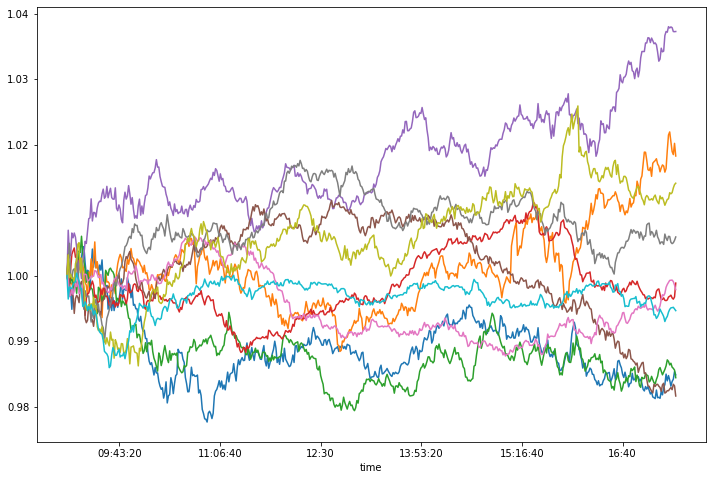

In [304]:
f, ax = plt.subplots(figsize= (12, 8))
df_cell.sample(1, axis=1).plot(ax=ax, legend=False)

<AxesSubplot:xlabel='datetime'>

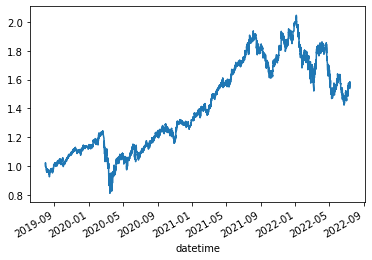

In [246]:
df.groupby(['datetime'])['pct_change'].prod().cumprod().plot()

<AxesSubplot:xlabel='date'>

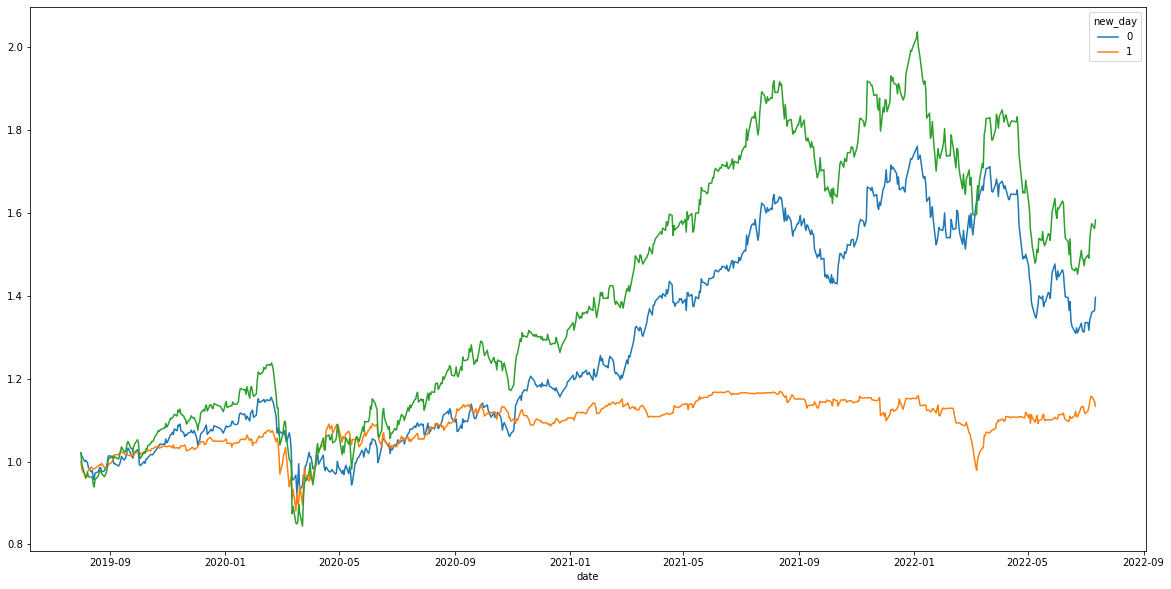

In [243]:
f, ax = plt.subplots(figsize= (20, 10))

df.groupby(['date', 'new_day'])['pct_change'].prod().unstack().fillna(1).cumprod().plot(ax=ax)
df.groupby(['date'])['pct_change'].prod().cumprod().plot(ax=ax)

In [183]:
df['pct_change'].prod()

1.5830616326546936

In [186]:
df.groupby('new_day')['pct_change'].prod()

1.5830616326548537

month            1         5                                          \
day             3         18        17        16        13        12   
time                                                                   
09:00:00  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
09:01:00  0.999671  1.001499  0.998749  0.998450  0.996873  1.000915   
09:02:00  0.999974  1.003049  1.000967  1.000511  0.994527  0.999504   
09:03:00  0.999846  1.002032  1.001313  1.001045  0.994001  0.999428   
09:04:00  1.000000  1.003105  1.003576  1.001856  0.994117  1.001334   
...            ...       ...       ...       ...       ...       ...   
17:20:00  1.012516  0.981967  1.008858  0.993982  1.013113  1.016063   
17:21:00  1.012560  0.981742  1.008836  0.993869  1.013627  1.014795   
17:22:00  1.012748  0.981473  1.008983  0.994175  1.014165  1.014694   
17:23:00  1.012481  0.980945  1.009308  0.993687  1.015297  1.013880   
17:24:00  1.012261  0.980597  1.009609  0.994028  1.014777  1.012788   

month                                             ...         2            \
day             11        10        9         6   ...        28        25   
time                                              ...                       
09:00:00  1.000000  1.000000  1.000000  1.000000  ...  1.000000  1.000000   
09:01:00  0.996484  0.999106  1.002545  0.998967  ...  1.006926  1.002174   
09:02:00  0.994806  0.996731  1.001442  0.997996  ...  1.003471  1.004300   
09:03:00  0.993427  0.998060  0.998891  0.996312  ...  1.003050  1.005621   
09:04:00  0.996625  0.994220  0.999994  0.998219  ...  1.006505  1.007200   
...            ...       ...       ...       ...  ...       ...       ...   
17:20:00  1.011163  0.997542  0.986615  0.988678  ...  1.037972  1.008936   
17:21:00  1.012214  0.997101  0.986019  0.989951  ...  1.037866  1.009363   
17:22:00  1.012671  0.997378  0.985839  0.990002  ...  1.037269  1.009594   
17:23:00  1.013047  0.997242  0.985564  0.990379  ...  1.037247  1.010115   
17:24:00  1.013716  0.997242  0.984408  0.989802  ...  1.037274  1.011036   

month                                                    4         7   2   7  
day             24        23        22        18        4         12  21  11  
time                                                                          
09:00:00  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000 NaN NaN  
09:01:00       NaN  1.001132  1.003841  1.000905  0.996021  1.000476 NaN NaN  
09:02:00       NaN  1.003520  1.005772  1.000453  0.994790  1.002611 NaN NaN  
09:03:00  0.948015  1.004066  1.009193  0.998225  0.995831  1.003184 NaN NaN  
09:04:00  0.950433  1.007123  1.011392  0.999507  0.997362  1.003019 NaN NaN  
...            ...       ...       ...       ...       ...       ...  ..  ..  
17:20:00  0.990462  0.979090  1.055371  0.984814  1.003822  1.022630 NaN NaN  
17:21:00  0.989542  0.977984  1.055420  0.984229  1.003803  1.022721 NaN NaN  
17:22:00  0.987802  0.977716  1.054874  0.984209  1.003774  1.023146 NaN NaN  
17:23:00  0.987318  0.977469  1.055147  0.984142  1.003346  1.023553 NaN NaN  
17:24:00  0.986024  0.978905  1.053805  0.984458  1.003627  1.024522 NaN NaN  

[505 rows x 131 columns]

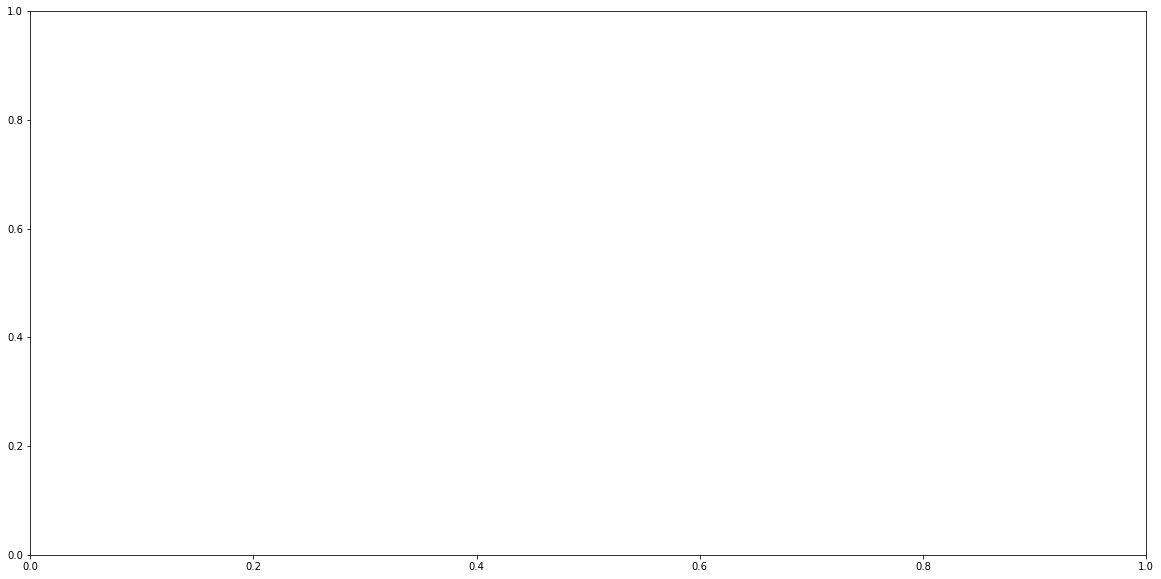

In [129]:
f, ax = plt.subplots(figsize= (20, 10))
df_cell = df[df['year']==2022].groupby(['month', 'day', 'time'])['close'].mean().unstack(level=[0,1])
df_cell.div(df_cell.iloc[0, :], axis=1).sort_values(by=df_cell.index[0], axis=1)#.plot(ax=ax, legend=False)